#### **Importing necessary libraries**

In [3]:
import csv
import math
import pickle
import datetime as dt
import pandas as pd
import pandas_profiling
import numpy as np
import warnings
import sklearn

from scipy import stats
from dateutil.parser import parse
from datetime import datetime
from IPython.display import display_html
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from yellowbrick.regressor import ResidualsPlot
from sklearn import linear_model
from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

/opt/conda/anaconda/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/opt/conda/anaconda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button style="color:"black";right:75%;" onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [4]:
######################################################################## ALL USER DEFINED FUNCTION ARE LOGGED HERE #############################################################################
################################################################################################################################################################################################

# calculate rmse scores
def rmse(pred_test, y_test):
    return np.sqrt(((pred_test - y_test) ** 2).mean())

# calculate mape scores
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# get names of all categorical data present in data
def get_index_of_categorical_columns(df):
    cols = df.columns
    num_cols = df._get_numeric_data().columns
    return list(set(cols) - set(num_cols))


def do_union(lst1, lst2, lst3, lst4): 
    final_list = list(set(lst1) | set(lst2) | set(lst3) | set(lst4))
    return final_list 

#### **Load IPL Analytical Dataset v10.4.0**

In [19]:
################################################################################# USER DEFINED FIELDS ###########################################################################################
#################################################################################################################################################################################################
####### Load ADS using name and path
#### Put name of the file as ads_name : name_of_my_ads
### Put the path is ads name : aes-analytics-0001-notebooks/Outage Restoration/Offshore_Gourav/CSV repo/

load_ads = pd.read_csv('gs://aes-datahub-0002-curated/Outage_Restoration/Historical_Data/Master_Dataset/OMS_IPL_OUTAGE_V10.4_IQR_08092020.csv')
print('\n')
display(load_ads.head())
print('\n')
print('\n')
print(list(load_ads.columns))

,DNI_EQUIP_TYPE,CALL_QTY,DOWNSTREAM_CUST_QTY,KEY_CUST_QTY,DAY_FLAG,TTR,POLE_CLUE_FLG,PART_LIGHT_CLUE_FLG,EMERGENCY_CLUE_FLG,POWER_OUT_CLUE_FLG,OPEN_DEVICE_CLUE_FLG,TREE_CLUE_FLG,WIRE_DOWN_CLUE_FLG,IVR_CLUE_FLG,EQUIPMENT_CLUE_FLG,TRANSFORMER_CLUE_FLG,OH_CAUSE_FLG,UG_CAUSE_FLG,ANIMAL_CAUSE_FLG,WEATHER_CAUSE_FLG,WEATHER_COLD_CAUSE_FLG,PUBLIC_CAUSE_FLG,WEATHER_LIGHTNING_CAUSE_FLG,WEATHER__SNOW_CAUSE_FLG,WEATHER__WIND_CAUSE_FLG,WEATHER__HEAT_CAUSE_FLG,CUST_REQUEST_CAUSE_FLG,WEATHER__FLOOD_CAUSE_FLG,STREET_CAUSE_FLG,SUBSTATION_CAUSE_FLG,TREE_CAUSE_FLG,MISCELLANEOUS_CAUSE_FLG,NO_CAUSE_FLG,PLANNED_CAUSE_FLG,NO_OUTAGE_CAUSE_FLG,FUSE_OCCURN_FLG,CUST_EQUIP_OCCURN_FLG,POLE_OCCURN_FLG,TRANSFORMER_OCCURN_FLG,METER_OCCURN_FLG,SERVICE_OCCURN_FLG,CABLE_OCCURN_FLG,ST_OCCURN_FLG,FIRE_OCCURN_FLG,FOUND_OPEN_OCCURN_FLG,PUBLIC_SAFETY_OCCURN_FLG,WIRE_OCCURN_FLG,SWITCH_OCCURN_FLG,REGULATOR_OCCURN_FLG,CUTOUT_OCCURN_FLG,CAP_BANK_OCCURN_FLG,RECLOSER_OCCURN_FLG,OH_OCCURN_FLG,PRIORITY_VAL_1.0,PRIORITY_VAL_2.0,PRIORITY_VAL_3.0,PRIORITY_VAL_5.0,CITY_NAM,ZONE,NO_OF_POWER_OUT_CLUE_PER_DAY,NO_OF_OPEN_DEVICE_CLUE_PER_DAY,NO_OF_IVR_CLUE_PER_DAY,NO_OF_ANIMAL_CAUSE_PER_DAY,NO_OF_WIRE_OCCURN_PER_DAY,Hour_Sin,Hour_Cos,RANK_SUBSEQUENT_OUTAGES,Outages_in_last_1hr,Outages_in_last_2hr,Outages_in_last_3hr,Outages_in_last_4hr,Outages_in_last_5hr,Outages_in_last_6hr,Outages_in_last_7hr,Outages_in_last_8hr,Outages_in_last_9hr,Outages_in_last_10hr,Weekday,Weekend_flag,Priority_Customer_Qty,Priority_Dist_Customer_Qty,Dispatch_Location,cldCvrAvg,cldCvrMax,cldCvrMin,dewPtAvg,dewPtMax,dewPtMin,feelsLikeAvg,feelsLikeMax,feelsLikeMin,heatIndexAvg,heatIndexMax,heatIndexMin,mslPresAvg,mslPresMax,mslPresMin,precip,radSolarAvg,radSolarMax,radSolarTot,relHumAvg,relHumMax,relHumMin,sfcPresAvg,sfcPresMax,sfcPresMin,snowfall,spcHumAvg,spcHumMax,spcHumMin,tempAvg,tempMax,tempMin,wetBulbAvg,wetBulbMax,wetBulbMin,windChillAvg,windChillMax,windChillMin,windDir100mAvg,windDir80mAvg,windDirAvg,windSpd100mAvg,windSpd100mMax,windSpd100mMin,windSpd80mAvg,windSpd80mMax,windSpd80mMin,windSpdAvg,windSpdMax,windSpdMin,tempRange,windSpdRange,sfcPresRange,cldCvrRange,relHumRange,relHumRatio,sfcPresRatio
0,SSUB,4,177.0,1.0,False,15.0000,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,INDIANAPOLIS,ZONE3,7,1,5,2,1,0.707107,7.071068e-01,1.0,0,0,0,0,0,0,0,0,0,0,Monday,False,1.0,1.0,ARL.,92.0,100.0,44.0,33.9,39.5,30.0,30.3,36.7,24.3,38.5,43.7,34.5,1016.4,1026.0,1008.9,0.0,28.5,125.4,684.3,83.3,90.3,79.3,986.8,995.8,980.1,0.0,4.2,5.2,3.6,38.5,43.7,34.5,36.6,41.7,32.8,30.3,36.7,24.3,269.0,269.0,267.0,16.8,20.3,8.8,17.0,20.6,8.9,14.4,17.8,6.7,9.2,11.1,15.7,56.0,11.0,1.138714,1.016019
1,FUSE,1,5.0,0.0,True,108.1667,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,INDIANAPOLIS,ZONE4,7,1,5,2,1,0.866025,-5.000000e-01,2.0,0,0,0,0,1,1,1,1,1,1,Monday,False,2.0,2.0,MILL,93.0,100.0,43.0,33.2,39.1,29.5,29.6,36.3,23.5,37.9,43.2,34.0,1016.9,1026.2,1009.3,0.0,29.0,127.2,695.3,83.0,90.0,79.0,986.8,995.7,980.1,0.0,4.1,5.2,3.5,37.9,43.2,34.0,36.0,41.3,32.2,29.6,36.3,23.5,270.0,271.0,268.0,16.8,20.2,8.7,16.9,20.5,8.8,14.4,17.8,6.7,9.2,11.1,15.6,57.0,11.0,1.139241,1.015917
2,1TBOH,2,6.0,0.0,True,39.6000,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,INDIANAPOLIS,ZONE4,7,1,5,2,1,0.70710





['DNI_EQUIP_TYPE', 'CALL_QTY', 'DOWNSTREAM_CUST_QTY', 'KEY_CUST_QTY', 'DAY_FLAG', 'TTR', 'POLE_CLUE_FLG', 'PART_LIGHT_CLUE_FLG', 'EMERGENCY_CLUE_FLG', 'POWER_OUT_CLUE_FLG', 'OPEN_DEVICE_CLUE_FLG', 'TREE_CLUE_FLG', 'WIRE_DOWN_CLUE_FLG', 'IVR_CLUE_FLG', 'EQUIPMENT_CLUE_FLG', 'TRANSFORMER_CLUE_FLG', 'OH_CAUSE_FLG', 'UG_CAUSE_FLG', 'ANIMAL_CAUSE_FLG', 'WEATHER_CAUSE_FLG', 'WEATHER_COLD_CAUSE_FLG', 'PUBLIC_CAUSE_FLG', 'WEATHER_LIGHTNING_CAUSE_FLG', 'WEATHER__SNOW_CAUSE_FLG', 'WEATHER__WIND_CAUSE_FLG', 'WEATHER__HEAT_CAUSE_FLG', 'CUST_REQUEST_CAUSE_FLG', 'WEATHER__FLOOD_CAUSE_FLG', 'STREET_CAUSE_FLG', 'SUBSTATION_CAUSE_FLG', 'TREE_CAUSE_FLG', 'MISCELLANEOUS_CAUSE_FLG', 'NO_CAUSE_FLG', 'PLANNED_CAUSE_FLG', 'NO_OUTAGE_CAUSE_FLG', 'FUSE_OCCURN_FLG', 'CUST_EQUIP_OCCURN_FLG', 'POLE_OCCURN_FLG', 'TRANSFORMER_OCCURN_FLG', 'METER_OCCURN_FLG', 'SERVICE_OCCURN_FLG', 'CABLE_OCCURN_FLG', 'ST_OCCURN_FLG', 'FIRE_OCCURN_FLG', 'FOUND_OPEN_OCCURN_FLG', 'PUBLIC_SAFETY_OCCURN_FLG', 'WIRE_OCCURN_FLG', 'SWIT

In [20]:
load_ads = load_ads[load_ads['TTR']>30]

In [21]:
load_ads.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69756 entries, 1 to 76775
Columns: 139 entries, DNI_EQUIP_TYPE to sfcPresRatio
dtypes: bool(53), float64(65), int64(16), object(5)
memory usage: 49.8+ MB


In [22]:
load_ads.describe()

,CALL_QTY,DOWNSTREAM_CUST_QTY,KEY_CUST_QTY,TTR,NO_OF_POWER_OUT_CLUE_PER_DAY,NO_OF_OPEN_DEVICE_CLUE_PER_DAY,NO_OF_IVR_CLUE_PER_DAY,NO_OF_ANIMAL_CAUSE_PER_DAY,NO_OF_WIRE_OCCURN_PER_DAY,Hour_Sin,Hour_Cos,RANK_SUBSEQUENT_OUTAGES,Outages_in_last_1hr,Outages_in_last_2hr,Outages_in_last_3hr,Outages_in_last_4hr,Outages_in_last_5hr,Outages_in_last_6hr,Outages_in_last_7hr,Outages_in_last_8hr,Outages_in_last_9hr,Outages_in_last_10hr,Priority_Customer_Qty,Priority_Dist_Customer_Qty,cldCvrAvg,cldCvrMax,cldCvrMin,dewPtAvg,dewPtMax,dewPtMin,feelsLikeAvg,feelsLikeMax,feelsLikeMin,heatIndexAvg,heatIndexMax,heatIndexMin,mslPresAvg,mslPresMax,mslPresMin,precip,radSolarAvg,radSolarMax,radSolarTot,relHumAvg,relHumMax,relHumMin,sfcPresAvg,sfcPresMax,sfcPresMin,snowfall,spcHumAvg,spcHumMax,spcHumMin,tempAvg,tempMax,tempMin,wetBulbAvg,wetBulbMax,wetBulbMin,windChillAvg,windChillMax,windChillMin,windDir100mAvg,windDir80mAvg,windDirAvg,windSpd100mAvg,windSpd100mMax,windSpd100mMin,windSpd80mAvg,windSpd80mMax,windSpd80mMin,windSpdAvg,windSpdMax,windSpdMin,tempRange,windSpdRange,sfcPresRange,cldCvrRange,relHumRange,relHumRatio,sfcPresRatio
count,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.00000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000,69756.000000
mean,13.817134,50.164172,0.352873,222.747802,49.954140,7.298842,22.075664,4.139257,13.433726,-0.061976,-0.251446,24.310267,6.766859,10.406890,13.278714,15.544756,17.608105,19.440192,21.145149,22.761856,24.267447,25.712096,24.663914,78.056683,53.203567,86.157363,18.996688,50.209581,55.602342,44.754408,58.472054,69.324288,48.090753,60.279074,70.422699,50.592755,1014.924189,1018.140040,1011.497136,0.250121,186.458680,653.203917,4474.829433,74.003952,91.294984,54.278998,986.565081,989.753023,983.181893,0.049016,9.370411,11.088223,7.796410,59.525050,68.798129,50.550737,54.455929,59.817644,48.361691,57.718080,67.699718,48.048736,201.926917,202.047164,201.82876,11.893450,17.842634,6.378203,12.054943,18.165600,6.430938,6.307023,11.466469,2.140113,18.247392,9.326356,6.571131,67.160674,37.015986,1.831279,1.006705
std,40.967773,191.034932,1.544639,366.143008,94.795386,7.995039,34.163361,3.999572,35.912979,0.705805,0.659383,48.525964,21.114305,30.336109,36.965464,40.882096,44.216738,47.006578,49.460187,51.777415,53.789109,55.665226,52.359388,369.530666,32.000295,27.655916,31.027018,17.625262,16.645804,18.781516,21.555355,22.509480,21.450283,18.967667,20.695380,18.209013,6.409622,6.190154,7.187091,0.477660,105.858699,284.932890,2540.623682,12.279382,7.999519,16.510290,6.319542,5.949885,7.292135,0.428113,4.840805,5.287741,4.467019,18.163982,19.046382,18.143142,16.507003,15.487871,17.746818,20.786339,20.918261,21.389480,87.467864,87.499479,87.16690,5.584763,7.486962,4.612225,5.630210,7.543234,4.649436,3.491249,5.476683,2.341293,6.619616,4.334104,4.756241,34.850376,14.007311,0.542552,0.004908
min,1.000000,1.000000,0.000000,30.016700,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00

#### **Columns with Categorical Values**

In [23]:
object_columns = load_ads.loc[:, (load_ads.dtypes == object) | (load_ads.dtypes == bool)]
print(list(object_columns.columns))

['DNI_EQUIP_TYPE', 'DAY_FLAG', 'POLE_CLUE_FLG', 'PART_LIGHT_CLUE_FLG', 'EMERGENCY_CLUE_FLG', 'POWER_OUT_CLUE_FLG', 'OPEN_DEVICE_CLUE_FLG', 'TREE_CLUE_FLG', 'WIRE_DOWN_CLUE_FLG', 'IVR_CLUE_FLG', 'EQUIPMENT_CLUE_FLG', 'TRANSFORMER_CLUE_FLG', 'OH_CAUSE_FLG', 'UG_CAUSE_FLG', 'ANIMAL_CAUSE_FLG', 'WEATHER_CAUSE_FLG', 'WEATHER_COLD_CAUSE_FLG', 'PUBLIC_CAUSE_FLG', 'WEATHER_LIGHTNING_CAUSE_FLG', 'WEATHER__SNOW_CAUSE_FLG', 'WEATHER__WIND_CAUSE_FLG', 'WEATHER__HEAT_CAUSE_FLG', 'CUST_REQUEST_CAUSE_FLG', 'WEATHER__FLOOD_CAUSE_FLG', 'STREET_CAUSE_FLG', 'SUBSTATION_CAUSE_FLG', 'TREE_CAUSE_FLG', 'MISCELLANEOUS_CAUSE_FLG', 'NO_CAUSE_FLG', 'PLANNED_CAUSE_FLG', 'NO_OUTAGE_CAUSE_FLG', 'FUSE_OCCURN_FLG', 'CUST_EQUIP_OCCURN_FLG', 'POLE_OCCURN_FLG', 'TRANSFORMER_OCCURN_FLG', 'METER_OCCURN_FLG', 'SERVICE_OCCURN_FLG', 'CABLE_OCCURN_FLG', 'ST_OCCURN_FLG', 'FIRE_OCCURN_FLG', 'FOUND_OPEN_OCCURN_FLG', 'PUBLIC_SAFETY_OCCURN_FLG', 'WIRE_OCCURN_FLG', 'SWITCH_OCCURN_FLG', 'REGULATOR_OCCURN_FLG', 'CUTOUT_OCCURN_FLG', '

#### **Dummifying Categorical Variables**

In [24]:
################################################################################# USER DEFINED FIELDS ###########################################################################################
#################################################################################################################################################################################################

select_columns_from_ads = ['CALL_QTY', 'DOWNSTREAM_CUST_QTY', 'KEY_CUST_QTY', 'DAY_FLAG', 'TTR', 'POLE_CLUE_FLG', 'PART_LIGHT_CLUE_FLG', 'EMERGENCY_CLUE_FLG',
                           'POWER_OUT_CLUE_FLG', 'OPEN_DEVICE_CLUE_FLG', 'TREE_CLUE_FLG', 'WIRE_DOWN_CLUE_FLG', 'IVR_CLUE_FLG', 'EQUIPMENT_CLUE_FLG',
                           'TRANSFORMER_CLUE_FLG', 'OH_CAUSE_FLG', 'UG_CAUSE_FLG', 'ANIMAL_CAUSE_FLG', 'WEATHER_CAUSE_FLG', 'WEATHER_COLD_CAUSE_FLG', 
                           'PUBLIC_CAUSE_FLG', 'WEATHER_LIGHTNING_CAUSE_FLG', 'WEATHER__SNOW_CAUSE_FLG', 'WEATHER__WIND_CAUSE_FLG', 'WEATHER__HEAT_CAUSE_FLG', 
                           'CUST_REQUEST_CAUSE_FLG', 'WEATHER__FLOOD_CAUSE_FLG', 'STREET_CAUSE_FLG', 'SUBSTATION_CAUSE_FLG', 'TREE_CAUSE_FLG', 'MISCELLANEOUS_CAUSE_FLG',
                           'NO_CAUSE_FLG', 'PLANNED_CAUSE_FLG', 'NO_OUTAGE_CAUSE_FLG', 'FUSE_OCCURN_FLG', 'CUST_EQUIP_OCCURN_FLG', 'POLE_OCCURN_FLG', 
                           'TRANSFORMER_OCCURN_FLG', 'METER_OCCURN_FLG', 'SERVICE_OCCURN_FLG', 'CABLE_OCCURN_FLG', 'ST_OCCURN_FLG', 'FIRE_OCCURN_FLG', 
                           'FOUND_OPEN_OCCURN_FLG', 'PUBLIC_SAFETY_OCCURN_FLG', 'WIRE_OCCURN_FLG', 'SWITCH_OCCURN_FLG', 'REGULATOR_OCCURN_FLG', 
                           'CUTOUT_OCCURN_FLG', 'CAP_BANK_OCCURN_FLG', 'RECLOSER_OCCURN_FLG', 'OH_OCCURN_FLG', 'PRIORITY_VAL_1.0', 'PRIORITY_VAL_2.0',
                           'PRIORITY_VAL_3.0', 'PRIORITY_VAL_5.0', 'CITY_NAM', 'ZONE', 'NO_OF_POWER_OUT_CLUE_PER_DAY', 'NO_OF_OPEN_DEVICE_CLUE_PER_DAY',
                           'NO_OF_IVR_CLUE_PER_DAY', 'NO_OF_ANIMAL_CAUSE_PER_DAY', 'NO_OF_WIRE_OCCURN_PER_DAY', 'Hour_Sin', 'Hour_Cos', 'RANK_SUBSEQUENT_OUTAGES', 
                           'Outages_in_last_1hr', 'Outages_in_last_2hr', 'Outages_in_last_3hr', 'Outages_in_last_4hr', 'Outages_in_last_5hr', 'Outages_in_last_6hr',
                           'Outages_in_last_7hr', 'Outages_in_last_8hr', 'Outages_in_last_9hr', 'Outages_in_last_10hr', 'Weekday', 'Weekend_flag',
                           'Priority_Customer_Qty', 'Priority_Dist_Customer_Qty', 'Dispatch_Location', 'cldCvrAvg', 'cldCvrMax', 'cldCvrMin', 'dewPtAvg', 
                           'dewPtMax', 'dewPtMin', 'feelsLikeAvg', 'feelsLikeMax', 'feelsLikeMin', 'heatIndexAvg', 'heatIndexMax', 'heatIndexMin', 'mslPresAvg',
                           'mslPresMax', 'mslPresMin', 'precip', 'radSolarAvg', 'radSolarMax', 'radSolarTot', 'relHumAvg', 'relHumMax', 'relHumMin', 'sfcPresAvg', 
                           'sfcPresMax', 'sfcPresMin', 'snowfall', 'spcHumAvg', 'spcHumMax', 'spcHumMin', 'tempAvg', 'tempMax', 'tempMin', 'wetBulbAvg', 'wetBulbMax',
                           'wetBulbMin', 'windChillAvg', 'windChillMax', 'windChillMin', 'windDir100mAvg', 'windDir80mAvg', 'windDirAvg', 'windSpd100mAvg',
                           'windSpd100mMax', 'windSpd100mMin', 'windSpd80mAvg', 'windSpd80mMax', 'windSpd80mMin', 'windSpdAvg', 'windSpdMax', 'windSpdMin', 
                           'tempRange', 'windSpdRange', 'sfcPresRange', 'cldCvrRange', 'relHumRange', 'relHumRatio', 'sfcPresRatio']

ads = load_ads[select_columns_from_ads]

ads = pd.get_dummies(ads, columns=['DAY_FLAG', 'POLE_CLUE_FLG', 'PART_LIGHT_CLUE_FLG', 'EMERGENCY_CLUE_FLG', 'POWER_OUT_CLUE_FLG', 
                                   'OPEN_DEVICE_CLUE_FLG', 'TREE_CLUE_FLG', 'WIRE_DOWN_CLUE_FLG', 'IVR_CLUE_FLG', 'EQUIPMENT_CLUE_FLG',
                                   'TRANSFORMER_CLUE_FLG', 'OH_CAUSE_FLG', 'UG_CAUSE_FLG', 'ANIMAL_CAUSE_FLG', 'WEATHER_CAUSE_FLG', 
                                   'WEATHER_COLD_CAUSE_FLG', 'PUBLIC_CAUSE_FLG', 'WEATHER_LIGHTNING_CAUSE_FLG', 'WEATHER__SNOW_CAUSE_FLG', 
                                   'WEATHER__WIND_CAUSE_FLG', 'WEATHER__HEAT_CAUSE_FLG', 'CUST_REQUEST_CAUSE_FLG', 'WEATHER__FLOOD_CAUSE_FLG', 
                                   'STREET_CAUSE_FLG', 'SUBSTATION_CAUSE_FLG', 'TREE_CAUSE_FLG', 'MISCELLANEOUS_CAUSE_FLG', 'NO_CAUSE_FLG', 
                                   'PLANNED_CAUSE_FLG', 'NO_OUTAGE_CAUSE_FLG', 'FUSE_OCCURN_FLG', 'CUST_EQUIP_OCCURN_FLG', 'POLE_OCCURN_FLG', 
                                   'TRANSFORMER_OCCURN_FLG', 'METER_OCCURN_FLG', 'SERVICE_OCCURN_FLG', 'CABLE_OCCURN_FLG', 'ST_OCCURN_FLG',
                                   'FIRE_OCCURN_FLG', 'FOUND_OPEN_OCCURN_FLG', 'PUBLIC_SAFETY_OCCURN_FLG', 'WIRE_OCCURN_FLG', 'SWITCH_OCCURN_FLG', 
                                   'REGULATOR_OCCURN_FLG', 'CUTOUT_OCCURN_FLG', 'CAP_BANK_OCCURN_FLG', 'RECLOSER_OCCURN_FLG', 'OH_OCCURN_FLG', 
                                   'PRIORITY_VAL_1.0', 'PRIORITY_VAL_2.0', 'PRIORITY_VAL_3.0', 'PRIORITY_VAL_5.0', 'CITY_NAM', 
                                   'ZONE', 'Weekday', 'Weekend_flag', 'Dispatch_Location'])

In [25]:
# print list of columns present in the ads and drop na's from the dataset
print(list(ads.columns))
ads.dropna(inplace=True)
print(ads.shape)

['CALL_QTY', 'DOWNSTREAM_CUST_QTY', 'KEY_CUST_QTY', 'TTR', 'NO_OF_POWER_OUT_CLUE_PER_DAY', 'NO_OF_OPEN_DEVICE_CLUE_PER_DAY', 'NO_OF_IVR_CLUE_PER_DAY', 'NO_OF_ANIMAL_CAUSE_PER_DAY', 'NO_OF_WIRE_OCCURN_PER_DAY', 'Hour_Sin', 'Hour_Cos', 'RANK_SUBSEQUENT_OUTAGES', 'Outages_in_last_1hr', 'Outages_in_last_2hr', 'Outages_in_last_3hr', 'Outages_in_last_4hr', 'Outages_in_last_5hr', 'Outages_in_last_6hr', 'Outages_in_last_7hr', 'Outages_in_last_8hr', 'Outages_in_last_9hr', 'Outages_in_last_10hr', 'Priority_Customer_Qty', 'Priority_Dist_Customer_Qty', 'cldCvrAvg', 'cldCvrMax', 'cldCvrMin', 'dewPtAvg', 'dewPtMax', 'dewPtMin', 'feelsLikeAvg', 'feelsLikeMax', 'feelsLikeMin', 'heatIndexAvg', 'heatIndexMax', 'heatIndexMin', 'mslPresAvg', 'mslPresMax', 'mslPresMin', 'precip', 'radSolarAvg', 'radSolarMax', 'radSolarTot', 'relHumAvg', 'relHumMax', 'relHumMin', 'sfcPresAvg', 'sfcPresMax', 'sfcPresMin', 'snowfall', 'spcHumAvg', 'spcHumMax', 'spcHumMin', 'tempAvg', 'tempMax', 'tempMin', 'wetBulbAvg', 'wetBu

#### **Target Variable Analysis: Is it Normal?**

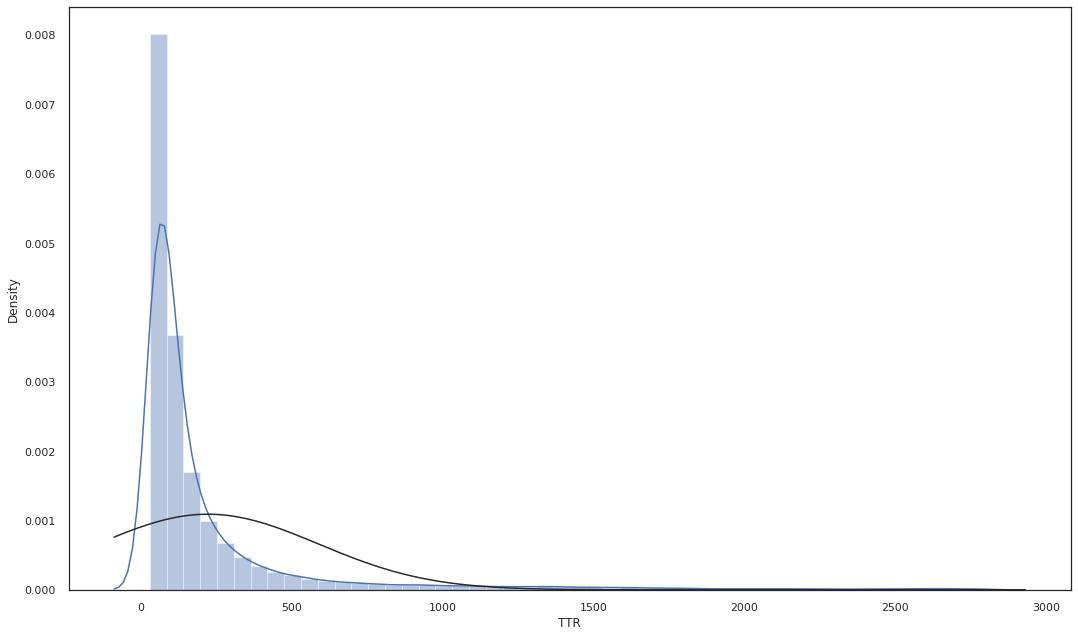

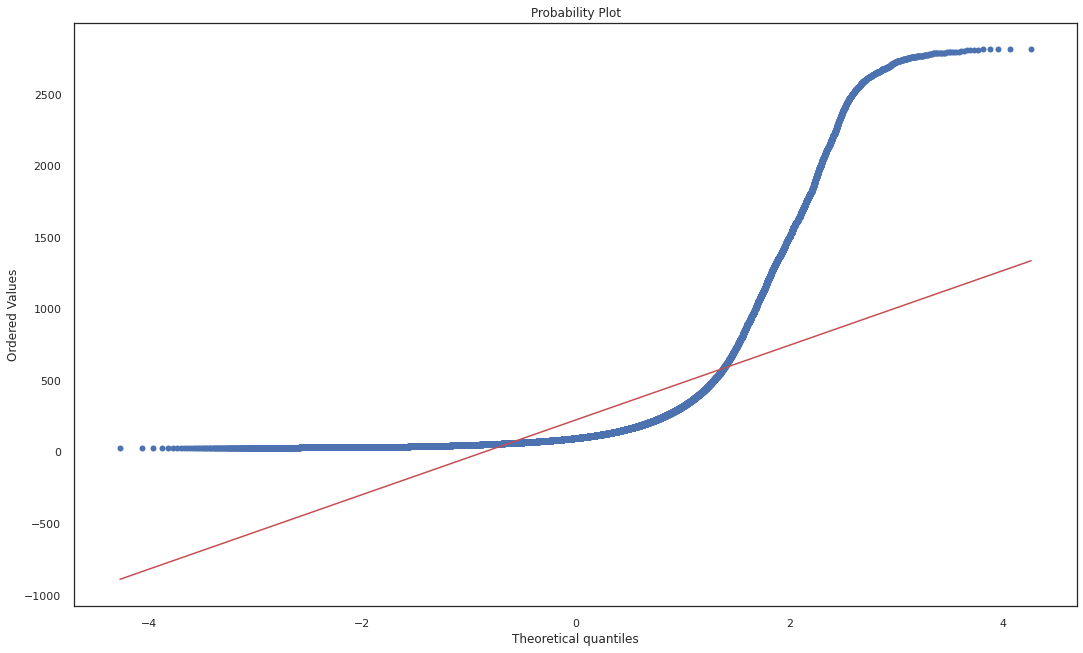

In [26]:
from scipy.stats import norm

sns.set(rc={'figure.figsize':(16,10)})
sns.set_style("white")

sns.distplot(ads['TTR'],fit=norm);
fig = plt.figure()
print('\n')
print('\n')
res = stats.probplot(ads['TTR'], plot=plt)

#### **Log Transformation of Tanget Variable (TTR)**

In [27]:
# Apply log e tranformation to the dataset
ads['TTR'] = np.log(ads['TTR'])

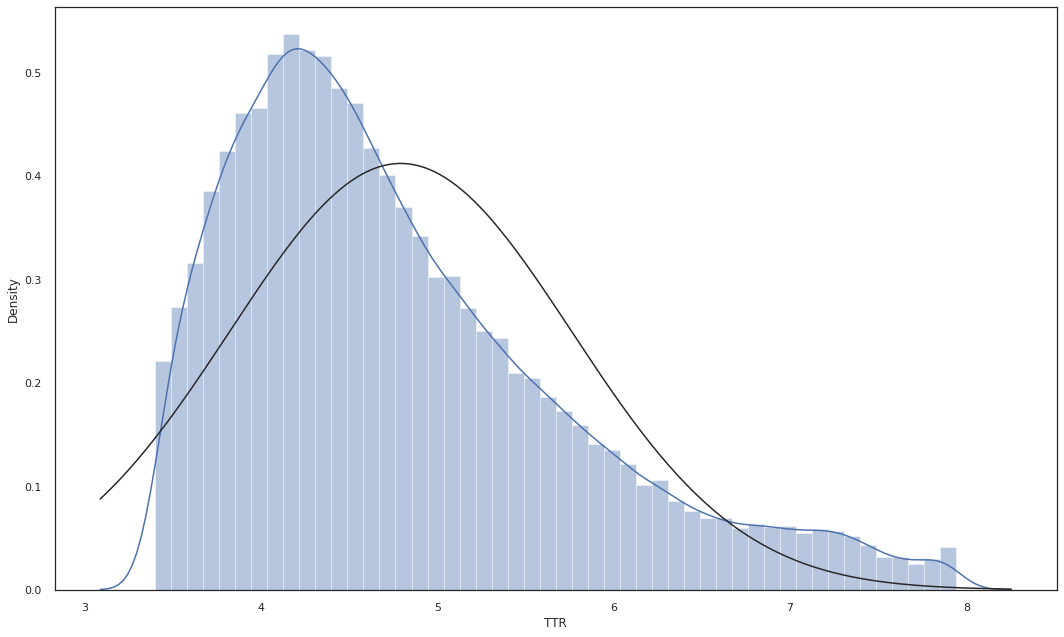

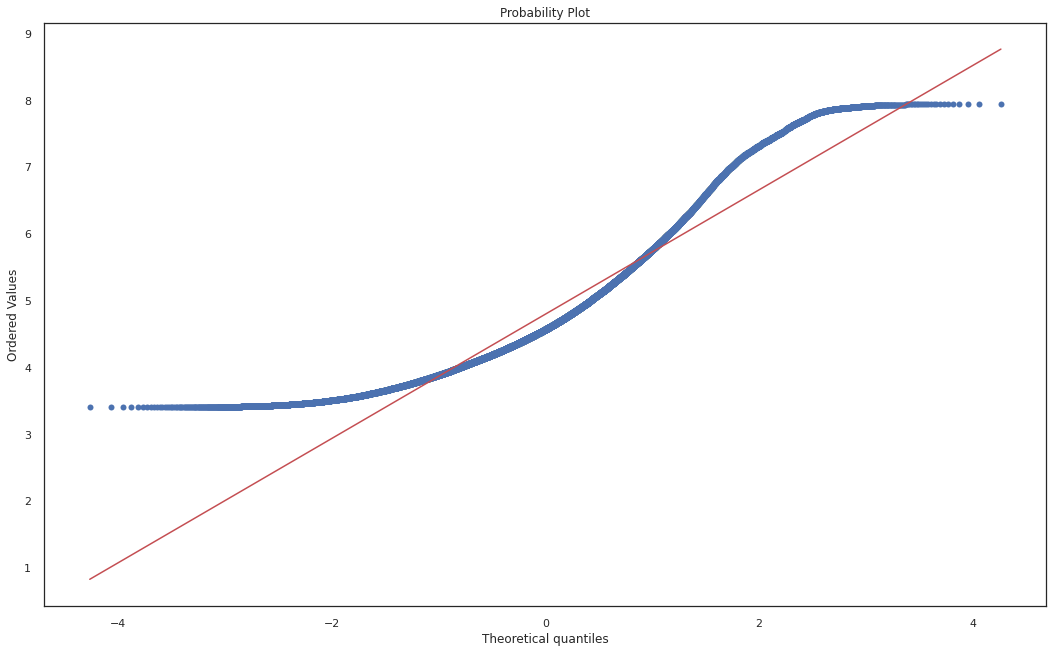

In [28]:
from scipy.stats import norm

sns.set(rc={'figure.figsize':(16,10)})
sns.set_style("white")

sns.distplot(ads['TTR'],fit=norm);
fig = plt.figure()
print('\n')
print('\n')
res = stats.probplot(ads['TTR'], plot=plt)

#### **Feature Selection using different Models**

In [29]:
%%time

#########################################################################################################################################################################################################
######################################################################## FEATURE SELECTION : MAX VOTING REGIME ##########################################################################################

X = ads.drop(['TTR'],axis=1)
y = ads['TTR']


lasso = LassoCV()
lasso.fit(X, y)
pls = PLSRegression(n_components=15)
pls.fit(X.values, y.values)
rf = RandomForestRegressor(n_jobs=-1)
rf.fit(X,y)
xg = xgb.XGBRegressor(n_jobs=-1)
xg.fit(X,y)

CPU times: user 15min 59s, sys: 19.5 s, total: 16min 19s
Wall time: 3min 6s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [30]:
lasso_reg = pd.DataFrame({'Features': X.columns, 'Importance_Score_Lasso': lasso.coef_}).sort_values(by='Importance_Score_Lasso',ascending=False)
pls_reg = pd.DataFrame({'Features': X.columns, 'Importance_Score_PLS': pls.coef_.ravel()}).sort_values(by='Importance_Score_PLS',ascending=False)
rftrees = pd.DataFrame({'Features': X.columns, 'Importance_Score_Random_Forest': rf.feature_importances_}).sort_values(by='Importance_Score_Random_Forest',ascending=False)
xgboost = pd.DataFrame({'Features': X.columns, 'Importance_Score_XGBoost': xg.feature_importances_}).sort_values(by='Importance_Score_XGBoost',ascending=False)


lasso_reg.reset_index(drop=True,inplace=True)
pls_reg.reset_index(drop=True,inplace=True)
rftrees.reset_index(drop=True,inplace=True)
xgboost.reset_index(drop=True,inplace=True)

lasso_reg = lasso_reg.head(15)
pls_reg = pls_reg.head(15)
rftrees = rftrees.head(15)
xgboost = xgboost.head(15)

#### **Feature Importance using Ordinary Least Square**

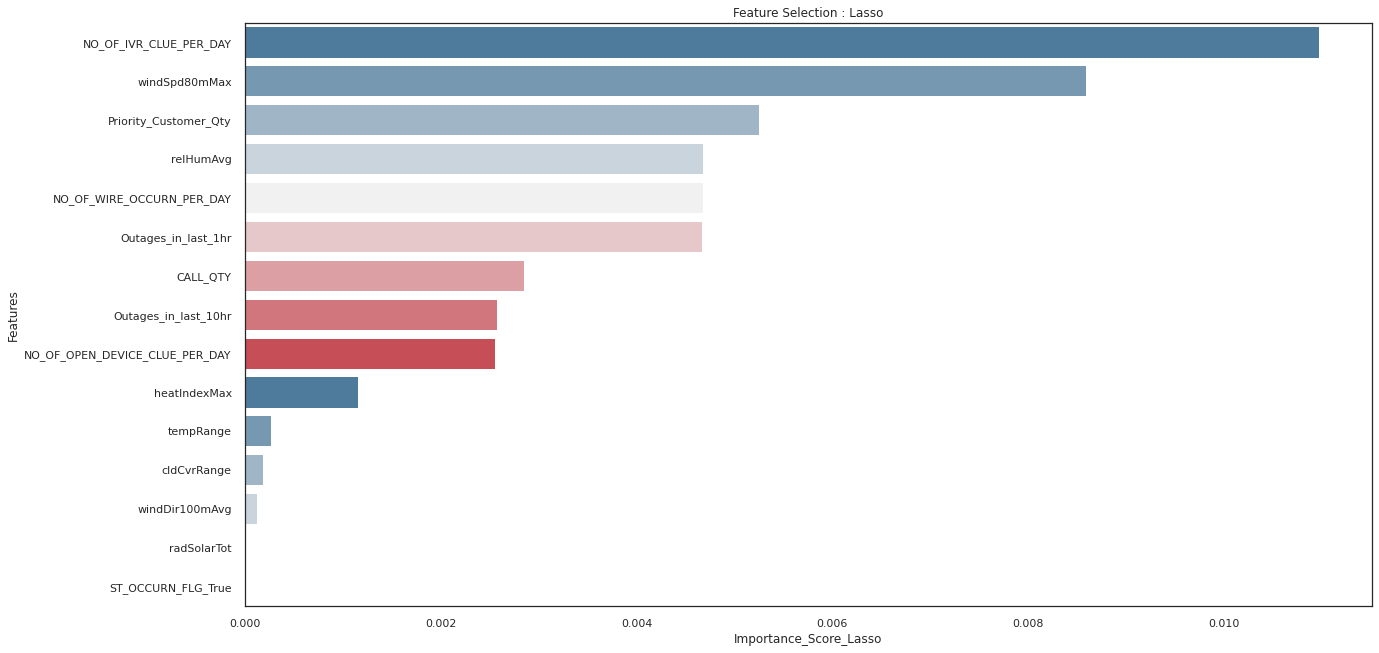

In [31]:
sns.set(rc={'figure.figsize':(18,10)})
sns.set_style("white")
ax = sns.barplot(x="Importance_Score_Lasso", y="Features", data=lasso_reg, palette = sns.diverging_palette(240, 10, n=9)).set_title('Feature Selection : Lasso')

In [32]:
print('\n')
print('\n')
display(lasso_reg)
print('\n')
print('\n')

,Features,Importance_Score_Lasso
0,NO_OF_IVR_CLUE_PER_DAY,0.010965
1,windSpd80mMax,0.008594
2,Priority_Customer_Qty,0.005255
3,relHumAvg,0.004683
4,NO_OF_WIRE_OCCURN_PER_DAY,0.004677
5,Outages_in_last_1hr,0.004665
6,CALL_QTY,0.002852
7,Outages_in_last_10hr,0.002576
8,NO_OF_OPEN_DEVICE_CLUE_PER_DAY,0.002556
9,heatIndexMax,0.001155


#### **Feature Importance using Partial Least Square**

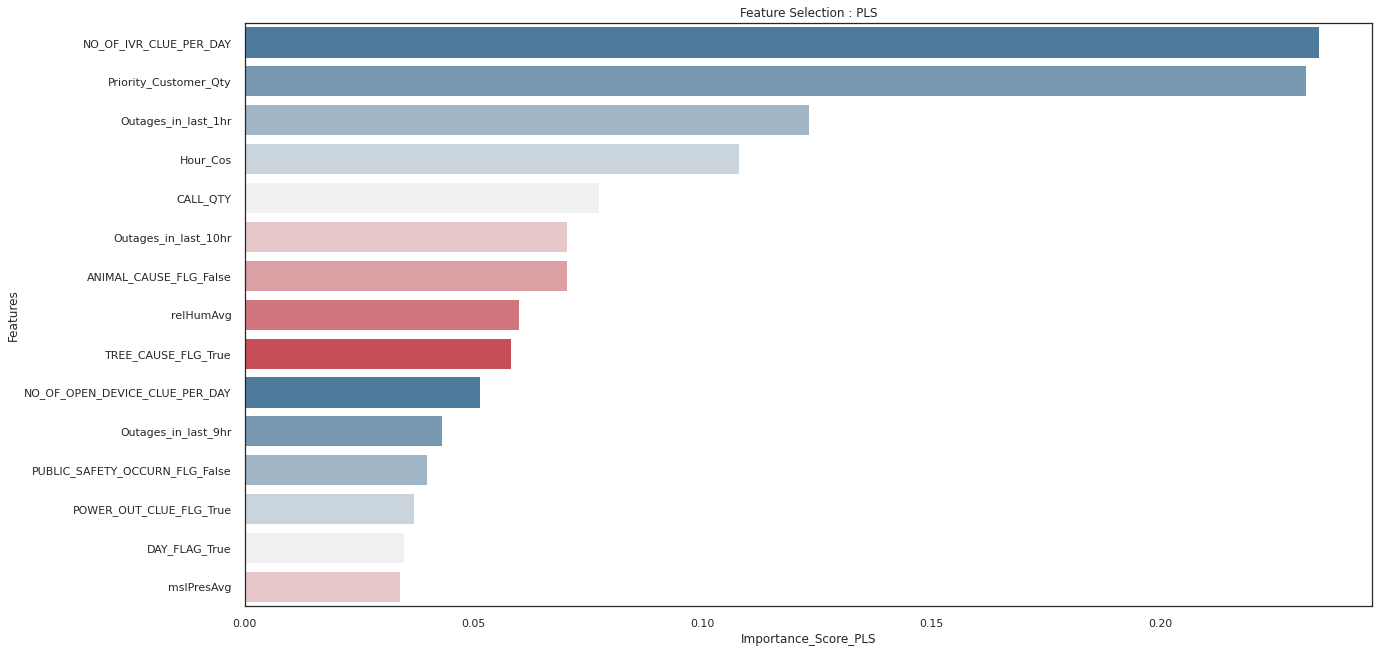

In [33]:
sns.set(rc={'figure.figsize':(18,10)})
sns.set_style("white")
ax = sns.barplot(x="Importance_Score_PLS", y="Features", data=pls_reg , palette = sns.diverging_palette(240, 10, n=9)).set_title('Feature Selection : PLS')

In [34]:
print('\n')
print('\n')
display(pls_reg)
print('\n')
print('\n')

,Features,Importance_Score_PLS
0,NO_OF_IVR_CLUE_PER_DAY,0.234654
1,Priority_Customer_Qty,0.232000
2,Outages_in_last_1hr,0.123246
3,Hour_Cos,0.107975
4,CALL_QTY,0.077445
5,Outages_in_last_10hr,0.070416
6,ANIMAL_CAUSE_FLG_False,0.070373
7,relHumAvg,0.059961
8,TREE_CAUSE_FLG_True,0.058204
9,NO_OF_OPEN_DEVICE_CLUE_PER_DAY,0.051319


#### **Feature Importance using Random Forest**

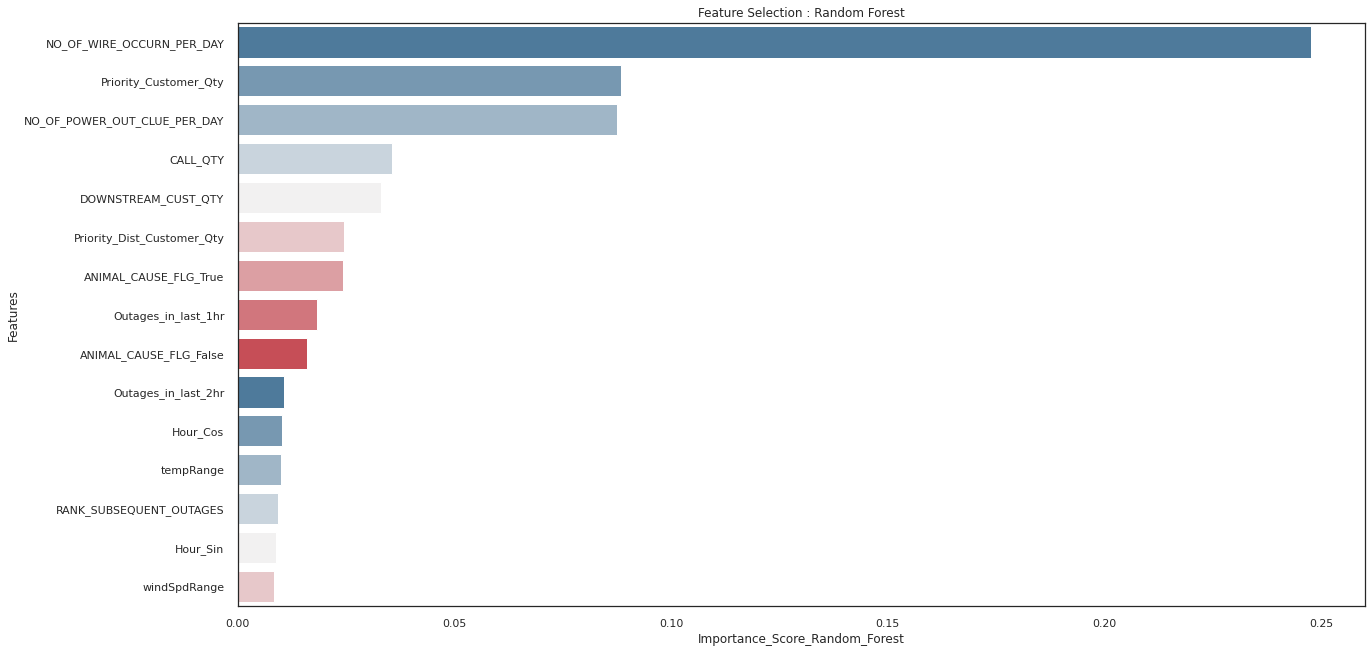

In [35]:
sns.set(rc={'figure.figsize':(18,10)})
sns.set_style("white")
ax = sns.barplot(x="Importance_Score_Random_Forest", y="Features", data=rftrees, palette = sns.diverging_palette(240, 10, n=9)).set_title('Feature Selection : Random Forest')

In [36]:
print('\n')
print('\n')
display(rftrees)
print('\n')
print('\n')

,Features,Importance_Score_Random_Forest
0,NO_OF_WIRE_OCCURN_PER_DAY,0.247755
1,Priority_Customer_Qty,0.088513
2,NO_OF_POWER_OUT_CLUE_PER_DAY,0.087593
3,CALL_QTY,0.035531
4,DOWNSTREAM_CUST_QTY,0.033085
5,Priority_Dist_Customer_Qty,0.024564
6,ANIMAL_CAUSE_FLG_True,0.024367
7,Outages_in_last_1hr,0.018271
8,ANIMAL_CAUSE_FLG_False,0.015978
9,Outages_in_last_2hr,0.010739


#### **Feature Importance using XGBoost**

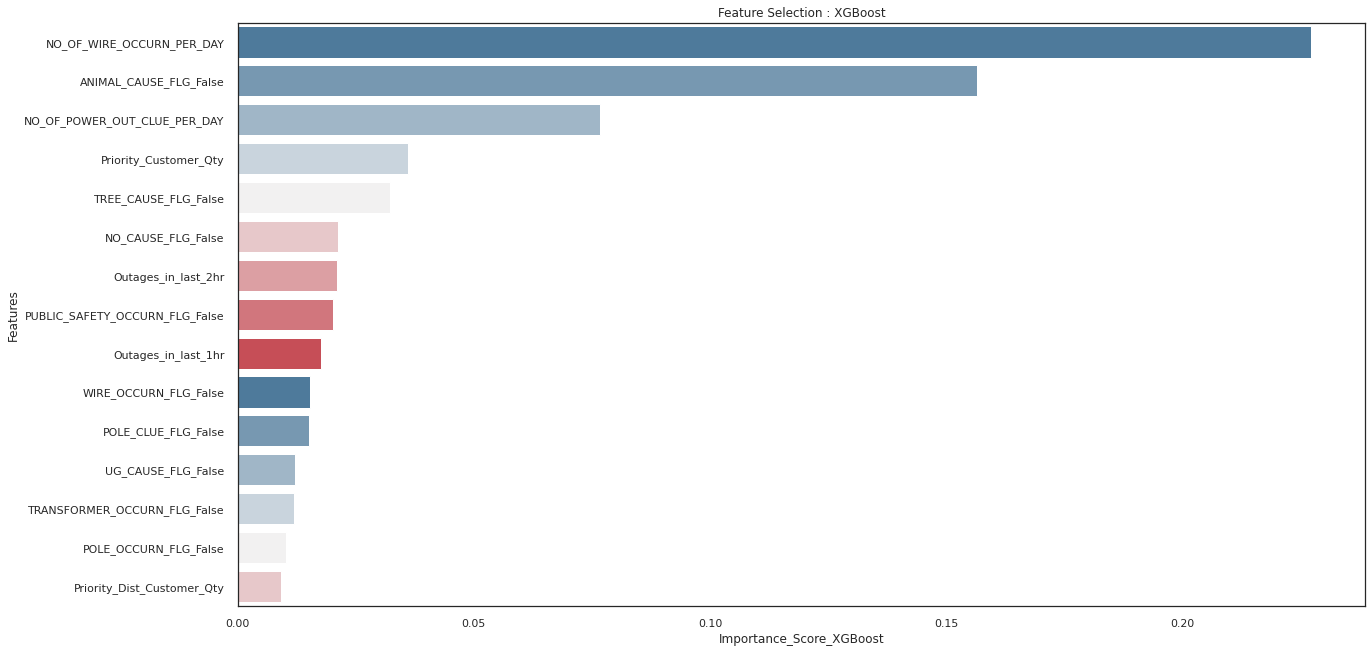

In [37]:
sns.set(rc={'figure.figsize':(18,10)})
sns.set_style("white")
ax = sns.barplot(x="Importance_Score_XGBoost", y="Features", data=xgboost, palette = sns.diverging_palette(240, 10, n=9)).set_title('Feature Selection : XGBoost')

In [38]:
print('\n')
print('\n')
display(xgboost)
print('\n')
print('\n')

,Features,Importance_Score_XGBoost
0,NO_OF_WIRE_OCCURN_PER_DAY,0.227322
1,ANIMAL_CAUSE_FLG_False,0.156627
2,NO_OF_POWER_OUT_CLUE_PER_DAY,0.076764
3,Priority_Customer_Qty,0.036006
4,TREE_CAUSE_FLG_False,0.032369
5,NO_CAUSE_FLG_False,0.021269
6,Outages_in_last_2hr,0.020976
7,PUBLIC_SAFETY_OCCURN_FLG_False,0.020234
8,Outages_in_last_1hr,0.017662
9,WIRE_OCCURN_FLG_False,0.015292


#### **Final Features Selected after Union (Max Voting Regime)**

In [39]:
final_features = do_union(list(xgboost.Features), list(rftrees.Features), list(lasso_reg.Features), list(pls_reg.Features))

print('\n')
print('\n')

display(final_features)
print('\n')
print(len(final_features), "No. of Features Selected")


print('\n')
print('\n')

['Outages_in_last_1hr',
 'Outages_in_last_10hr',
 'windSpd80mMax',
 'heatIndexMax',
 'ANIMAL_CAUSE_FLG_True',
 'Outages_in_last_9hr',
 'DOWNSTREAM_CUST_QTY',
 'ST_OCCURN_FLG_True',
 'NO_OF_IVR_CLUE_PER_DAY',
 'Outages_in_last_2hr',
 'CALL_QTY',
 'PUBLIC_SAFETY_OCCURN_FLG_False',
 'Priority_Dist_Customer_Qty',
 'windDir100mAvg',
 'Hour_Cos',
 'TREE_CAUSE_FLG_False',
 'NO_OF_WIRE_OCCURN_PER_DAY',
 'TRANSFORMER_OCCURN_FLG_False',
 'Priority_Customer_Qty',
 'TREE_CAUSE_FLG_True',
 'DAY_FLAG_True',
 'UG_CAUSE_FLG_False',
 'WIRE_OCCURN_FLG_False',
 'ANIMAL_CAUSE_FLG_False',
 'RANK_SUBSEQUENT_OUTAGES',
 'windSpdRange',
 'Hour_Sin',
 'POLE_CLUE_FLG_False',
 'cldCvrRange',
 'mslPresAvg',
 'POWER_OUT_CLUE_FLG_True',
 'POLE_OCCURN_FLG_False',
 'NO_OF_POWER_OUT_CLUE_PER_DAY',
 'relHumAvg',
 'tempRange',
 'radSolarTot',
 'NO_CAUSE_FLG_False',
 'NO_OF_OPEN_DEVICE_CLUE_PER_DAY']



38 No. of Features Selected






#### **View Data-set after feature selection**

In [40]:
ads_v1 = ads[final_features]
ads_v1['TTR'] = ads['TTR']
print('\n')
print('\n')
display(ads_v1.head())
print('\n')
print('\n')

,Outages_in_last_1hr,Outages_in_last_10hr,windSpd80mMax,heatIndexMax,ANIMAL_CAUSE_FLG_True,Outages_in_last_9hr,DOWNSTREAM_CUST_QTY,ST_OCCURN_FLG_True,NO_OF_IVR_CLUE_PER_DAY,Outages_in_last_2hr,CALL_QTY,PUBLIC_SAFETY_OCCURN_FLG_False,Priority_Dist_Customer_Qty,windDir100mAvg,Hour_Cos,TREE_CAUSE_FLG_False,NO_OF_WIRE_OCCURN_PER_DAY,TRANSFORMER_OCCURN_FLG_False,Priority_Customer_Qty,TREE_CAUSE_FLG_True,DAY_FLAG_True,UG_CAUSE_FLG_False,WIRE_OCCURN_FLG_False,ANIMAL_CAUSE_FLG_False,RANK_SUBSEQUENT_OUTAGES,windSpdRange,Hour_Sin,POLE_CLUE_FLG_False,cldCvrRange,mslPresAvg,POWER_OUT_CLUE_FLG_True,POLE_OCCURN_FLG_False,NO_OF_POWER_OUT_CLUE_PER_DAY,relHumAvg,tempRange,radSolarTot,NO_CAUSE_FLG_False,NO_OF_OPEN_DEVICE_CLUE_PER_DAY,TTR
1,0,1,20.5,43.2,0,1,5.0,0,5,0,1,1,2.0,270.0,-5.000000e-01,1,1,1,2.0,0,1,1,1,1,2.0,11.1,0.866025,1,57.0,1016.9,0,1,7,83.0,9.2,695.3,1,1,4.683674
2,0,2,20.5,42.9,1,2,6.0,0,5,1,2,1,1.0,269.0,-7.071068e-01,1,1,1,1.0,0,1,1,1,0,3.0,11.1,0.707107,1,58.0,1016.7,1,1,7,83.7,8.8,707.0,1,1,3.678829
3,1,5,20.5,43.2,1,5,12.0,0,5,3,6,1,2.0,270.0,-9.659258e-01,1,1,1,1.0,0,1,1,1,0,6.0,11.1,0.258819,1,57.0,1016.9,1,1,7,83.0,9.2,695.3,1,1,4.169246
4,0,2,11.3,38.9,0,1,1.0,0,3,0,1,1,16.0,214.0,6.123234e-17,1,1,1,8.0,0,1,1,1,1,2.0,6.3,1.000000,1,100.0,1029.2,1,1,13,89.0,8.9,908.9,1,4,4.309008
5,0,3,11.9,38.3,0,3,6.0,0,3,2,4,1,11.0,212.0,-5.000000e-01,1,1,1,5.0,0,1,0,1,1,4.0,6.1,0.866025,1,100.0,1029.1,1,1,13,89.2,8.4,914.0,1,4,3.914021


#### **Correlation Matrix of Selected Variables**

<AxesSubplot:>

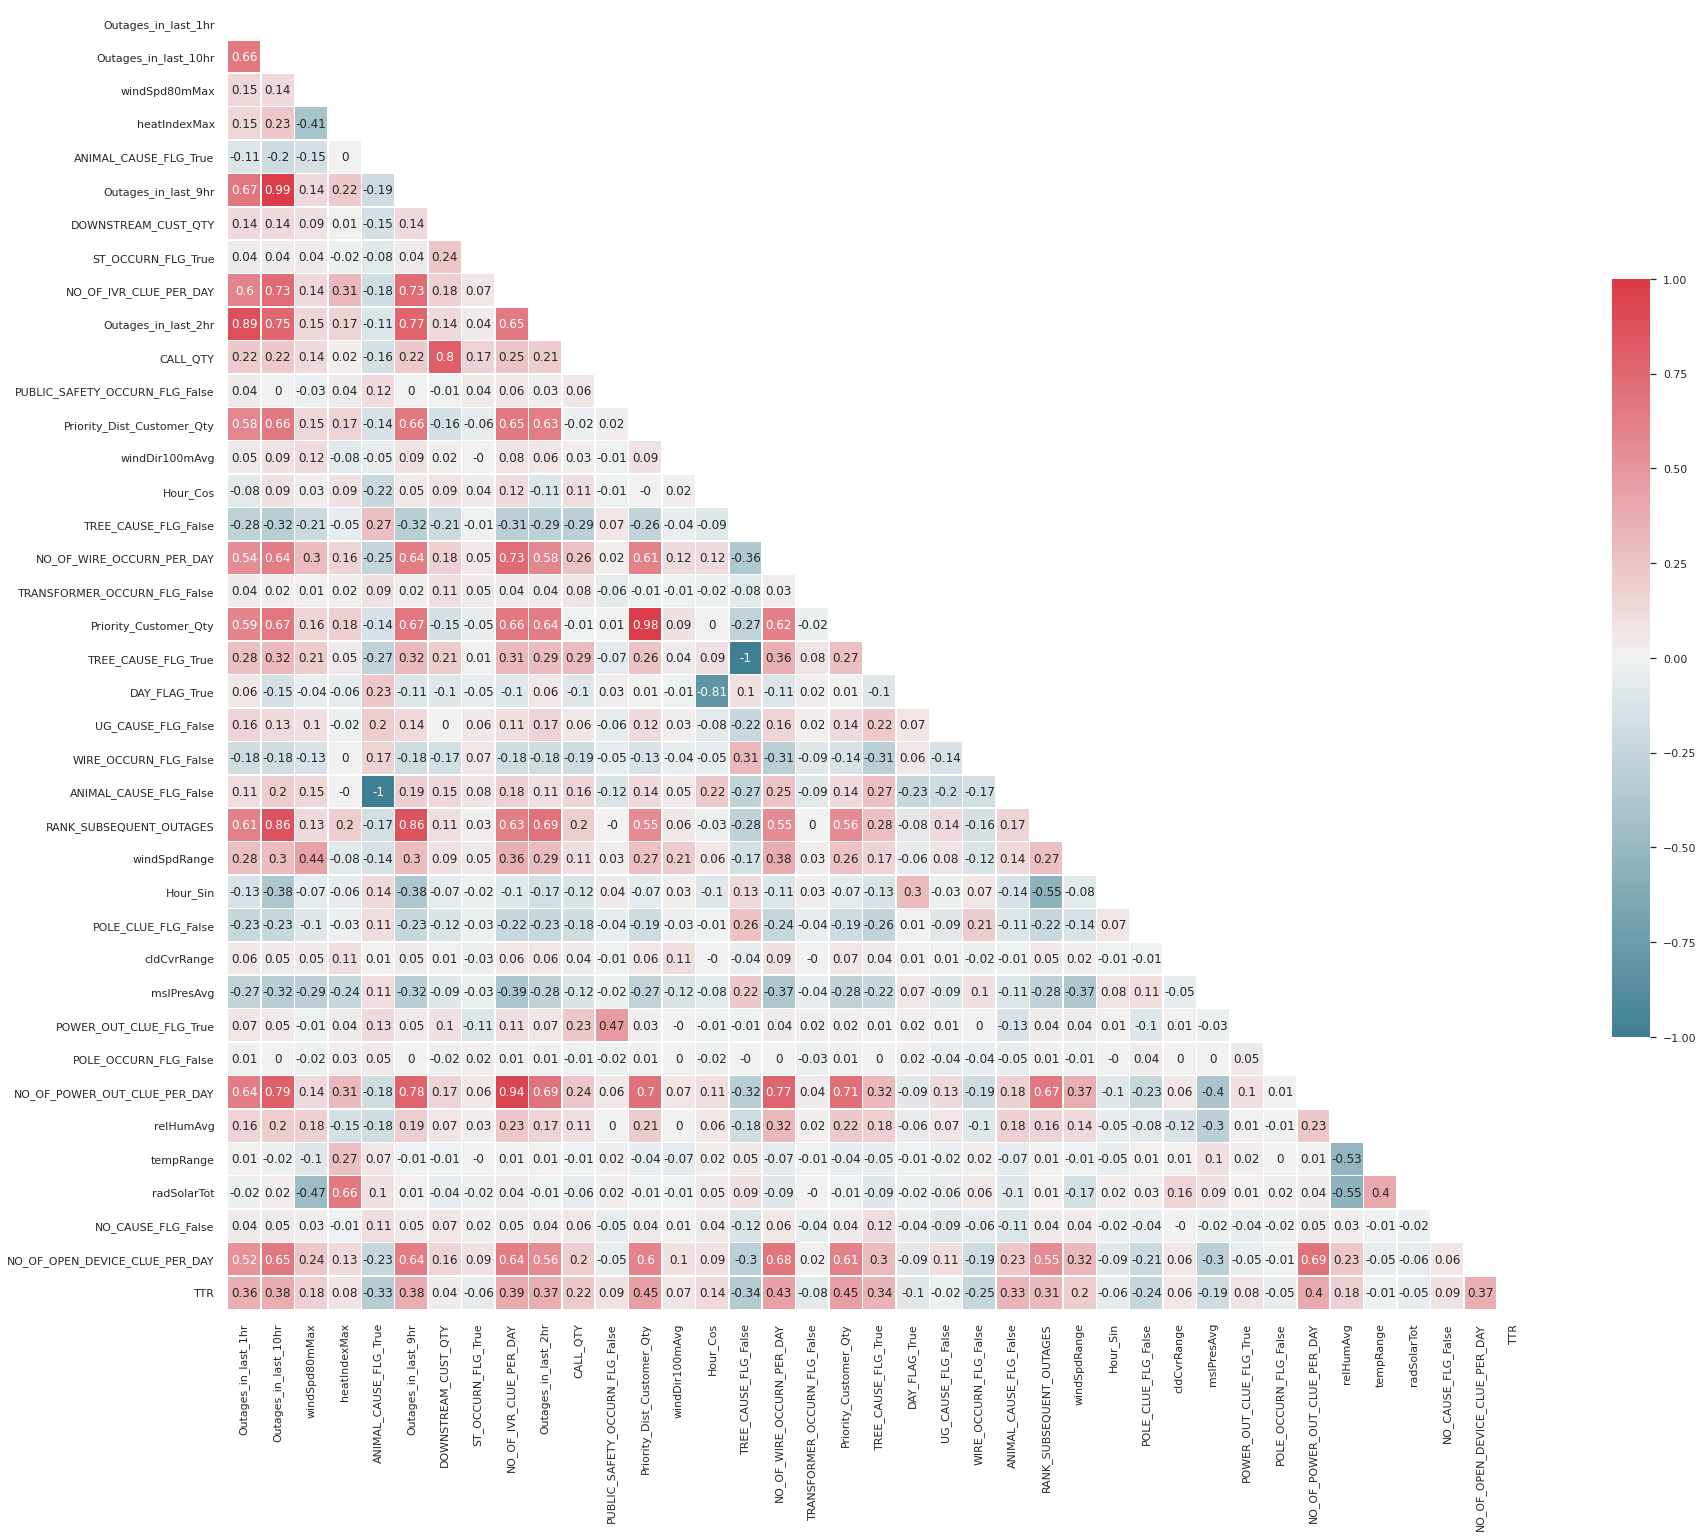

In [41]:
#whitegrid
sns.set_style('whitegrid')
#compute correlation matrix...
corr_matrix=ads_v1.corr(method='spearman')
#...and show it with a heatmap
#first define the dimension
plt.figure(figsize=(26,26))

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(round(corr_matrix,2), mask=mask, cmap=cmap, center=0, vmax=1, vmin =-1, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### **BoxPlot of selected Variables**

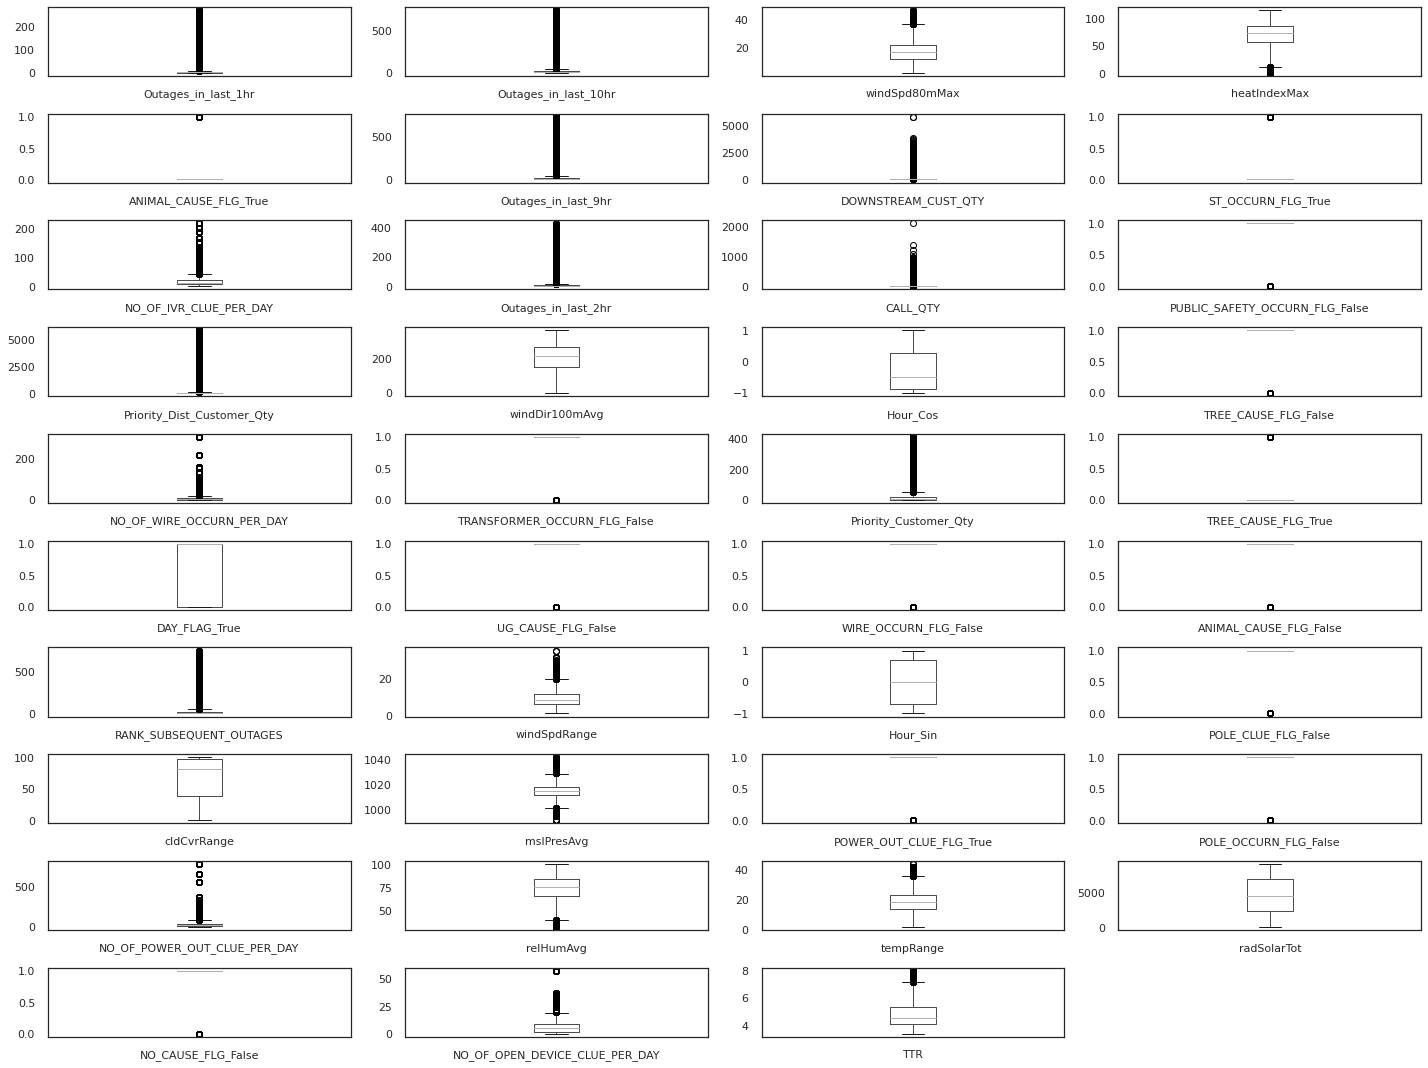

In [42]:
sns.set(rc={'figure.figsize':(20,15)})
sns.set_style("white")
for i, col in enumerate(list(ads_v1.columns.values)):
    plt.subplot(10,4,i+1)
    ads_v1.boxplot(col)
    plt.grid()
    plt.tight_layout()

#### **Distribution Plot of selectedf Variables**

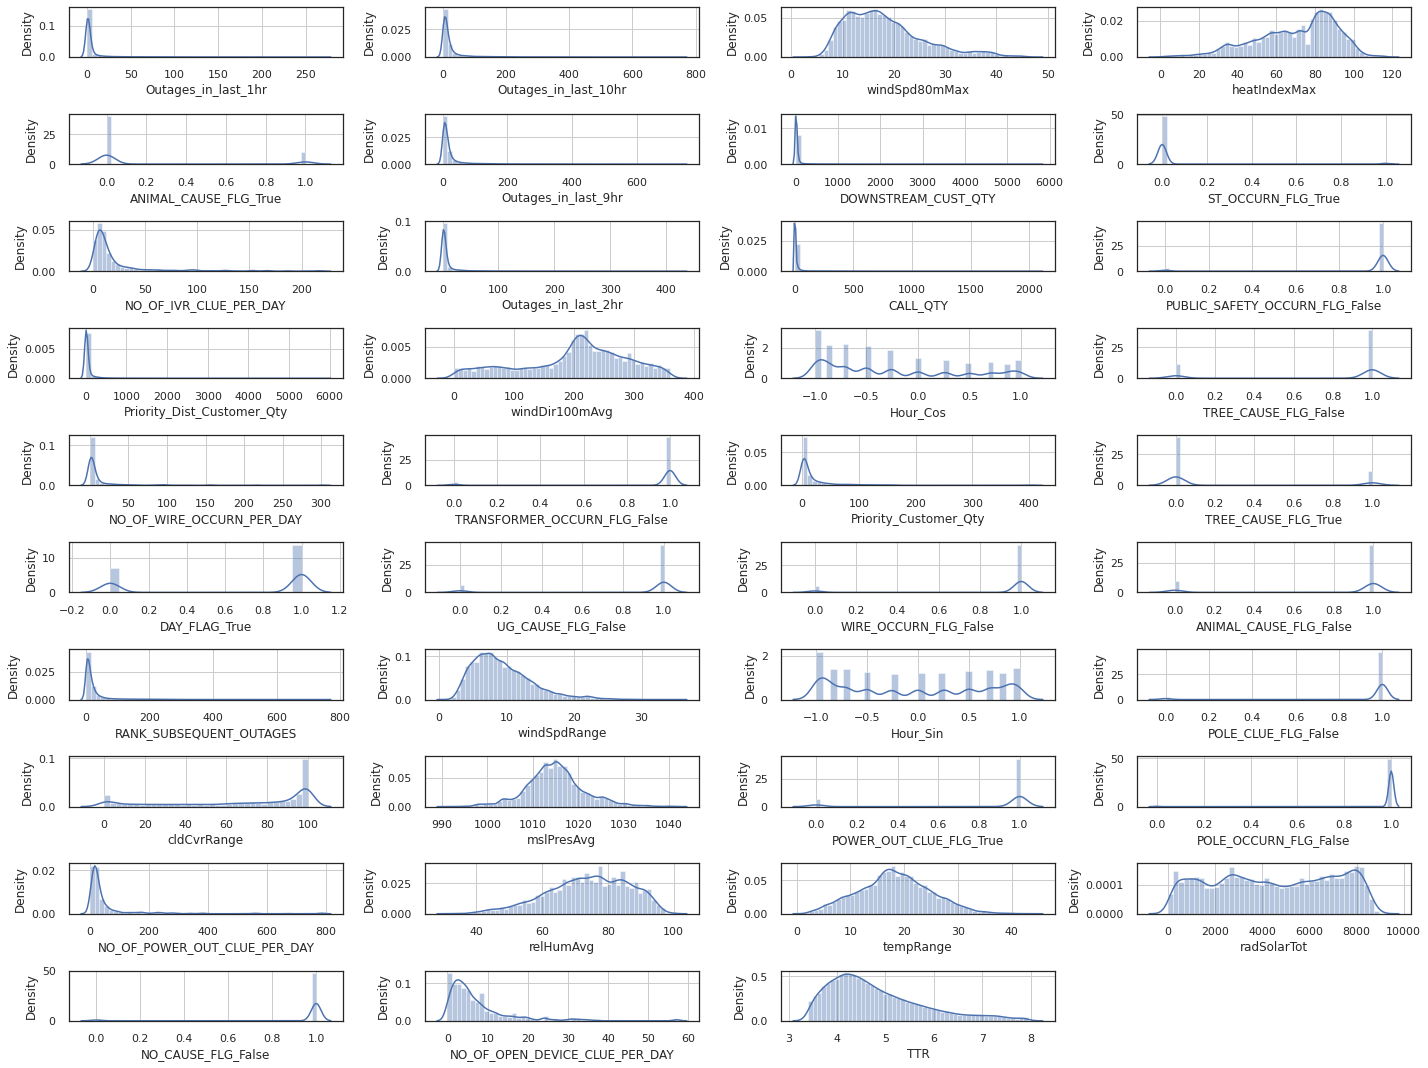

In [43]:
sns.set(rc={'figure.figsize':(20,15)})
sns.set_style("white")
for i, col in enumerate(list(ads_v1.columns.values)):
    plt.subplot(10,4,i+1)
    sns.distplot(ads_v1[col], color='b', kde=True, label='data')
    plt.grid()
    plt.tight_layout()

#### **Train-Test Split using sklearn**

In [44]:
X = ads[final_features]
y = ads['TTR']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('\n')
print('\n')
print(len(X_train),len(X_test))
print(len(y_train),len(y_test))
print('\n')
print('\n')





55804 13952
55804 13952






#### **Building Baseline Random Forest Model**
- A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting
- The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), otherwise the whole dataset is used to build each tree.

In [45]:
model_col = ['MODEL_NAME' , 'TRAIN_MSE', 'TRAIN_RMSE', 'TRAIN_MAE', 'TRAIN_MAPE', 'TRAIN_R2', 'TEST_MSE', 'TEST_RMSE', 'TEST_MAE', 'TEST_MAPE', 'TEST_R2']
model_result_df = pd.DataFrame(columns=model_col)
data_train_list = pd.DataFrame() 
data_test_list = pd.DataFrame() 
i=0

In [46]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_jobs = -1, random_state = 42)

rf.fit(X_train, y_train)

y_train_pred = rf.predict(X_train)
y_train_pred = np.exp(y_train_pred)

y_test_pred = rf.predict(X_test)
y_test_pred = np.exp(y_test_pred)

y_train = np.exp(y_train)
y_test = np.exp(y_test)

mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = rmse(y_train,y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mape_train = mean_absolute_percentage_error(y_train,y_train_pred)
r2_train = r2_score(y_train,y_train_pred)
                   
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = rmse(y_test,y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
mape_test = mean_absolute_percentage_error(y_test,y_test_pred)
r2_test = r2_score(y_test,y_test_pred)

data_train = pd.DataFrame({'Model':'Random Forest Baseline', 'Train_Predicted': list(y_train_pred),'Train_Actual': list(y_train) })
data_train_list = data_train_list.append(data_train)
data_train_list.reset_index(drop=True, inplace=True)

data_test = pd.DataFrame({'Model':'Random Forest Baseline', 'Test_Predicted': list(y_test_pred),'Test_Actual': list(y_test)})
data_test_list = data_test_list.append(data_test)
data_test_list.reset_index(drop=True, inplace=True)

model_result_df.loc[i] = ['Random Forest Baseline', mse_train, rmse_train, mae_train, mape_train, r2_train, mse_test, rmse_test, mae_test, mape_test, r2_test]
i = i + 1

In [47]:
model_result_df.head()

,MODEL_NAME,TRAIN_MSE,TRAIN_RMSE,TRAIN_MAE,TRAIN_MAPE,TRAIN_R2,TEST_MSE,TEST_RMSE,TEST_MAE,TEST_MAPE,TEST_R2
0,Random Forest Baseline,8805.76947,93.839062,39.781766,17.527186,0.93447,41388.349849,203.441269,96.264686,51.804597,0.688311


In [48]:
y_train = np.log(y_train)
y_test = np.log(y_test)

#### **Random Forest Baseline: Actual vs Fitted PLot**

Text(0.5, 1.0, 'Actual vs Fitted : Random Forest Baseline')

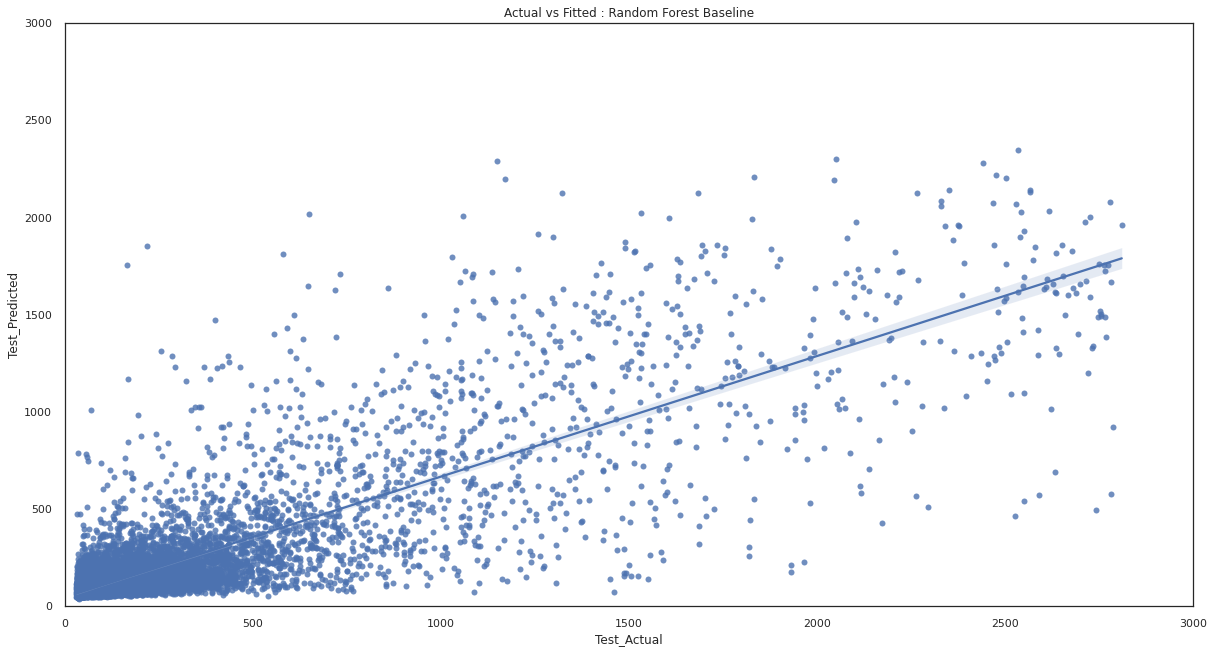

In [49]:
sns.set(rc={'figure.figsize':(18,10)})
sns.set_style("white")
ax = sns.regplot(x="Test_Actual", y="Test_Predicted", data=data_test_list[data_test_list.Model=='Random Forest Baseline'])
ax.set_xlim(0,3000)
ax.set_ylim(0,3000)
ax.set_title('Actual vs Fitted : Random Forest Baseline')

#### **Random Forest Baseline : Residual PLot**

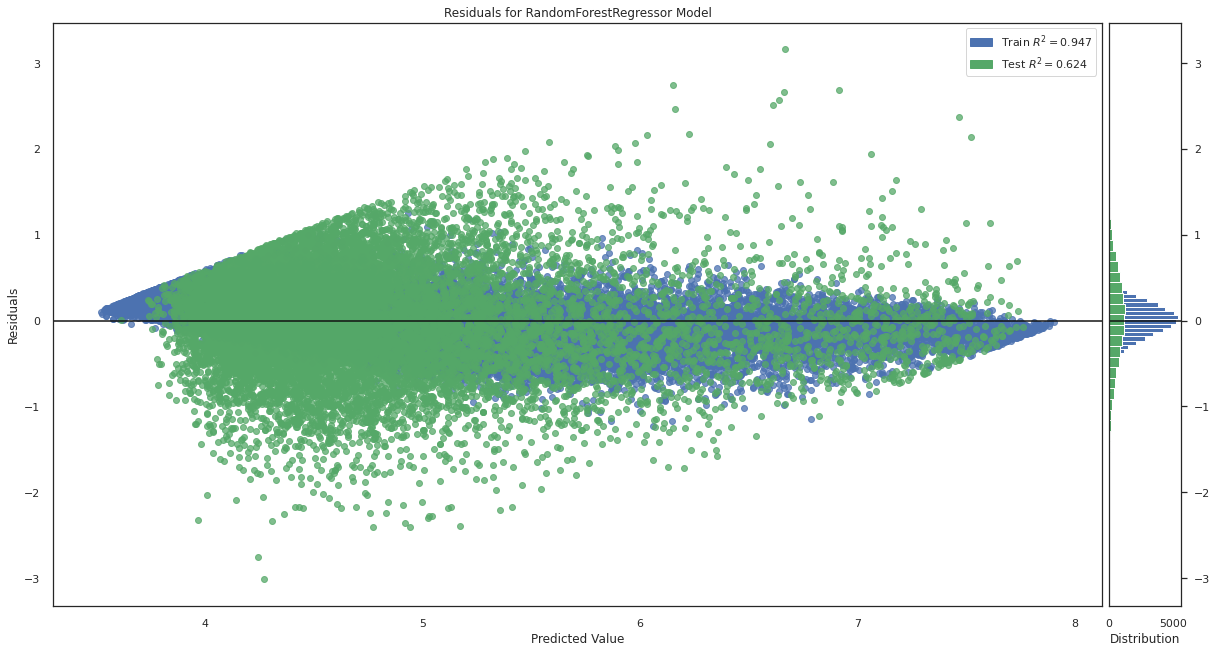

<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [50]:
sns.set(rc={'figure.figsize':(18,10)})
sns.set_style("white")

visualizer = ResidualsPlot(rf)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data

visualizer.show()                 # Finalize and render the figure

#### **Random Forest Parameters**
- n_estimators = number of trees in the foreset
- max_features = max number of features considered for splitting a node
- max_depth = max number of levels in each decision tree
- min_samples_split = min number of data points placed in a node before the node is split
- min_samples_leaf = min number of data points allowed in a leaf node
- bootstrap = method for sampling data points (with or without replacement)

In [33]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [51]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 5)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 60, num = 5)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 22, 35, 47, 60, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 325, 550, 775, 1000]}


#### **Random Search Training**
- The most important arguments in RandomizedSearchCV are n_iter, which controls the number of different combinations to try, and cv which is the number of folds to use for cross validation (we use 100 and 3 respectively)
- More iterations will cover a wider search space and more cv folds reduces the chances of overfitting, but raising each will increase the run time. Machine learning is a field of trade-offs, and performance vs time is one of the most fundamental.

In [ ]:
%%time

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 150, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 21.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 118.8min


In [38]:
print(rf_random.best_params_)

{'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 60, 'bootstrap': True}


#### **Building Random Search Best Model**

In [39]:
rf = RandomForestRegressor(n_jobs=-1, random_state=42)
rf.set_params(**rf_random.best_params_)

rf.fit(X_train, y_train)

y_train_pred = rf.predict(X_train)
y_train_pred = np.exp(y_train_pred)

y_test_pred = rf.predict(X_test)
y_test_pred = np.exp(y_test_pred)

y_train = np.exp(y_train)
y_test = np.exp(y_test)

mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = rmse(y_train,y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mape_train = mean_absolute_percentage_error(y_train,y_train_pred)
r2_train = r2_score(y_train,y_train_pred)
                   
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = rmse(y_test,y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
mape_test = mean_absolute_percentage_error(y_test,y_test_pred)
r2_test = r2_score(y_test,y_test_pred)

data_train = pd.DataFrame({'Model':'Random Forest Random Search', 'Train_Predicted': list(y_train_pred),'Train_Actual': list(y_train) })
data_train_list = data_train_list.append(data_train)
data_train_list.reset_index(drop=True, inplace=True)

data_test = pd.DataFrame({'Model':'Random Forest Random Search', 'Test_Predicted': list(y_test_pred),'Test_Actual': list(y_test)})
data_test_list = data_test_list.append(data_test)
data_test_list.reset_index(drop=True, inplace=True)

model_result_df.loc[i] = ['Random Forest Random Search', mse_train, rmse_train, mae_train, mape_train, r2_train, mse_test, rmse_test, mae_test, mape_test, r2_test]
i = i + 1

In [40]:
model_result_df.head()

,MODEL_NAME,TRAIN_MSE,TRAIN_RMSE,TRAIN_MAE,TRAIN_MAPE,TRAIN_R2,TEST_MSE,TEST_RMSE,TEST_MAE,TEST_MAPE,TEST_R2
0,Random Forest Baseline,8920.022221,94.445869,38.487242,19.818482,0.928097,39853.505268,199.633427,93.009311,63.138280,0.692941
1,Random Forest Random Search,16178.281870,127.193875,53.019043,28.745888,0.869588,40295.571184,200.737568,93.307486,63.107006,0.689535


In [41]:
y_train = np.log(y_train)
y_test = np.log(y_test)

#### **Random Forest Random Search: Actual vs Fitted PLot**

Text(0.5, 1.0, 'Actual vs Fitted : Random Forest Random Search')

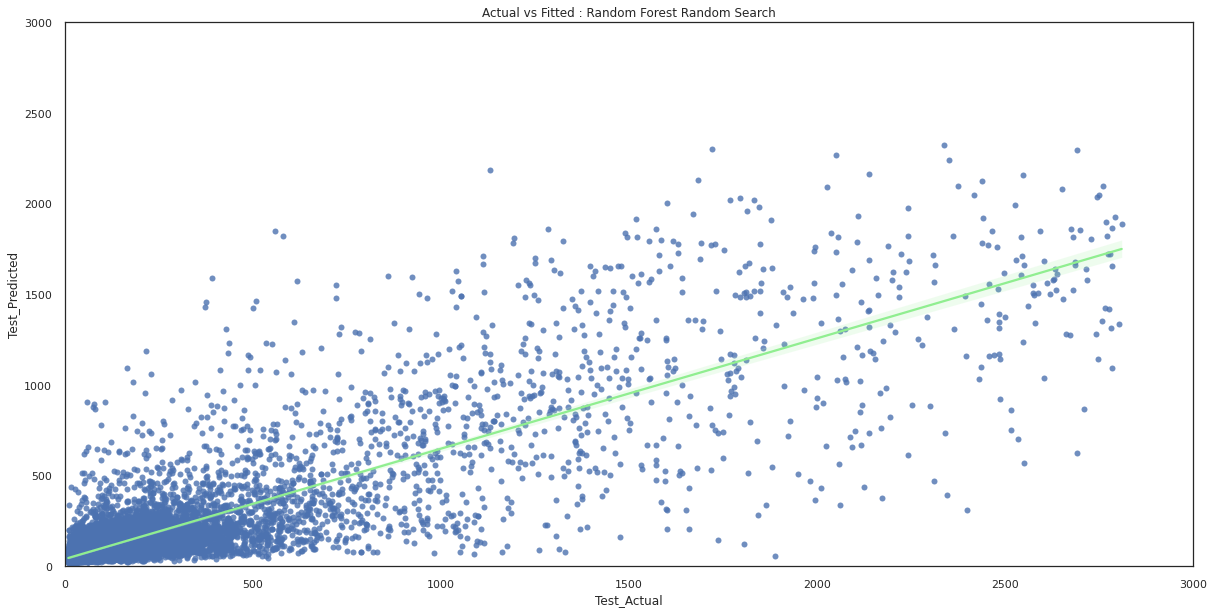

In [42]:
sns.set(rc={'figure.figsize':(18,10)})
sns.set_style("white")
ax = sns.regplot(x="Test_Actual", y="Test_Predicted", data=data_test_list[data_test_list.Model=='Random Forest Random Search'], line_kws={"color": "lightgreen"})
ax.set_xlim(0,3000)
ax.set_ylim(0,3000)
ax.set_title('Actual vs Fitted : Random Forest Random Search')

#### **Random Forest Random Search: Residual PLot**

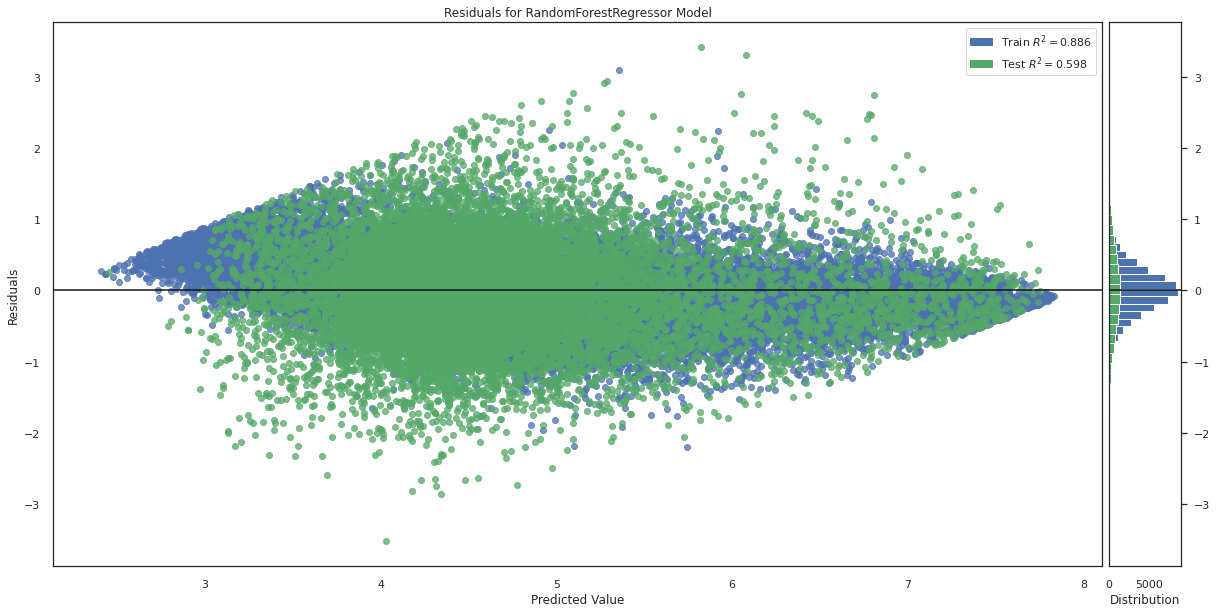

<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [43]:
sns.set(rc={'figure.figsize':(18,10)})
sns.set_style("white")

visualizer = ResidualsPlot(rf)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data

visualizer.show()                 # Finalize and render the figure

#### **Grid Search with Cross Validation**
- Random search allowed us to narrow down the range for each hyperparameter
- Now that we know where to concentrate our search, we can explicitly specify every combination of settings to try
- We do this with GridSearchCV, a method that, instead of sampling randomly from a distribution, evaluates all combinations we define.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 60, 70],
    'max_features': [2, 3],
    'min_samples_leaf': [0, 1, 2],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [80, 90, 100, 110, 150]
}

# Create a based model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

print("Best Paramters for Random Forest Model using Grid Search:")
print(grid_search.best_params_)

Fitting 3 folds for each of 270 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed: 11.5min finished


Best Paramters for Random Forest Model using Grid Search:
{'bootstrap': True, 'max_depth': 60, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 150}


#### **Building Grid Search Best Model**

In [45]:
rf = RandomForestRegressor(n_jobs=-1, random_state=42)
rf.set_params(**grid_search.best_params_)

rf.fit(X_train, y_train)

y_train_pred = rf.predict(X_train)
y_train_pred = np.exp(y_train_pred)

y_test_pred = rf.predict(X_test)
y_test_pred = np.exp(y_test_pred)

y_train = np.exp(y_train)
y_test = np.exp(y_test)

mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = rmse(y_train,y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mape_train = mean_absolute_percentage_error(y_train,y_train_pred)
r2_train = r2_score(y_train,y_train_pred)
                   
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = rmse(y_test,y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
mape_test = mean_absolute_percentage_error(y_test,y_test_pred)
r2_test = r2_score(y_test,y_test_pred)

data_train = pd.DataFrame({'Model':'Random Forest Grid Search', 'Train_Predicted': list(y_train_pred),'Train_Actual': list(y_train) })
data_train_list = data_train_list.append(data_train)
data_train_list.reset_index(drop=True, inplace=True)

data_test = pd.DataFrame({'Model':'Random Forest Grid Search', 'Test_Predicted': list(y_test_pred),'Test_Actual': list(y_test)})
data_test_list = data_test_list.append(data_test)
data_test_list.reset_index(drop=True, inplace=True)

model_result_df.loc[i] = ['Random Forest Grid Search', mse_train, rmse_train, mae_train, mape_train, r2_train, mse_test, rmse_test, mae_test, mape_test, r2_test]
i = i + 1

In [46]:
model_result_df.head()

,MODEL_NAME,TRAIN_MSE,TRAIN_RMSE,TRAIN_MAE,TRAIN_MAPE,TRAIN_R2,TEST_MSE,TEST_RMSE,TEST_MAE,TEST_MAPE,TEST_R2
0,Random Forest Baseline,8920.022221,94.445869,38.487242,19.818482,0.928097,39853.505268,199.633427,93.009311,63.138280,0.692941
1,Random Forest Random Search,16178.281870,127.193875,53.019043,28.745888,0.869588,40295.571184,200.737568,93.307486,63.107006,0.689535
2,Random Forest Grid Search,22426.981585,149.756407,63.889492,35.102882,0.819218,46024.809905,214.533936,98.254456,64.193754,0.645393


In [47]:
y_train = np.log(y_train)
y_test = np.log(y_test)

#### **Random Forest Grid Search: Actual vs Fitted Plot**

Text(0.5, 1.0, 'Actual vs Fitted : Random Forest Grid Search CV')

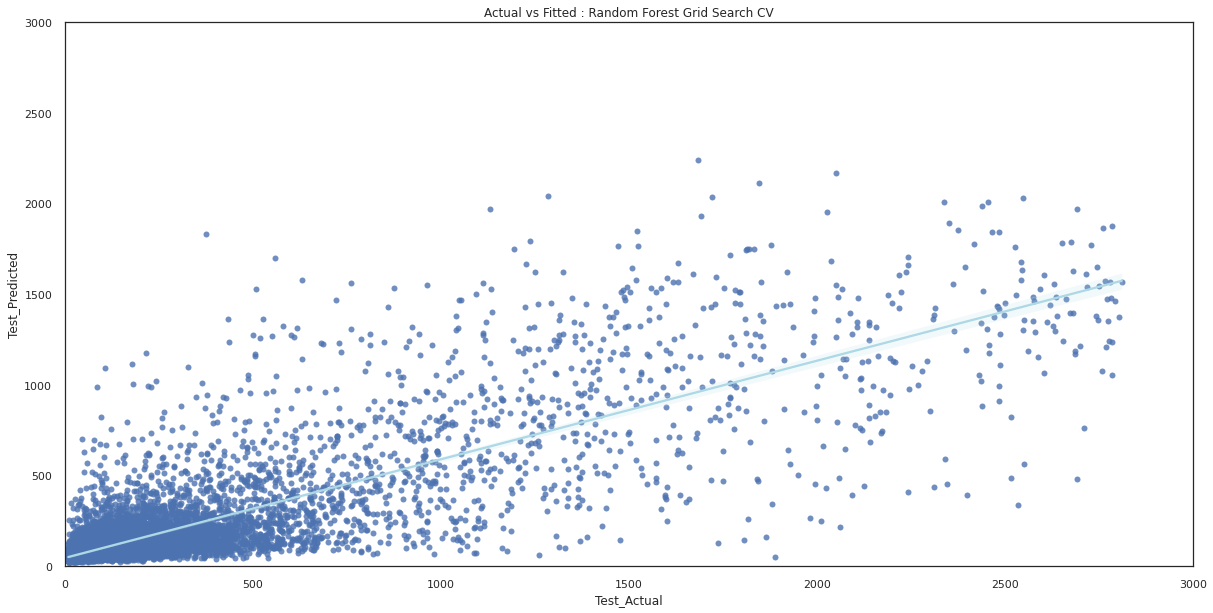

In [48]:
ax = sns.regplot(x="Test_Actual", y="Test_Predicted", data=data_test_list[data_test_list.Model=='Random Forest Grid Search'], line_kws={"color": "lightblue"})
ax.set_xlim(0,3000)
ax.set_ylim(0,3000)
ax.set_title('Actual vs Fitted : Random Forest Grid Search CV')

#### **Random Forest Grid Search: Residual PLot**

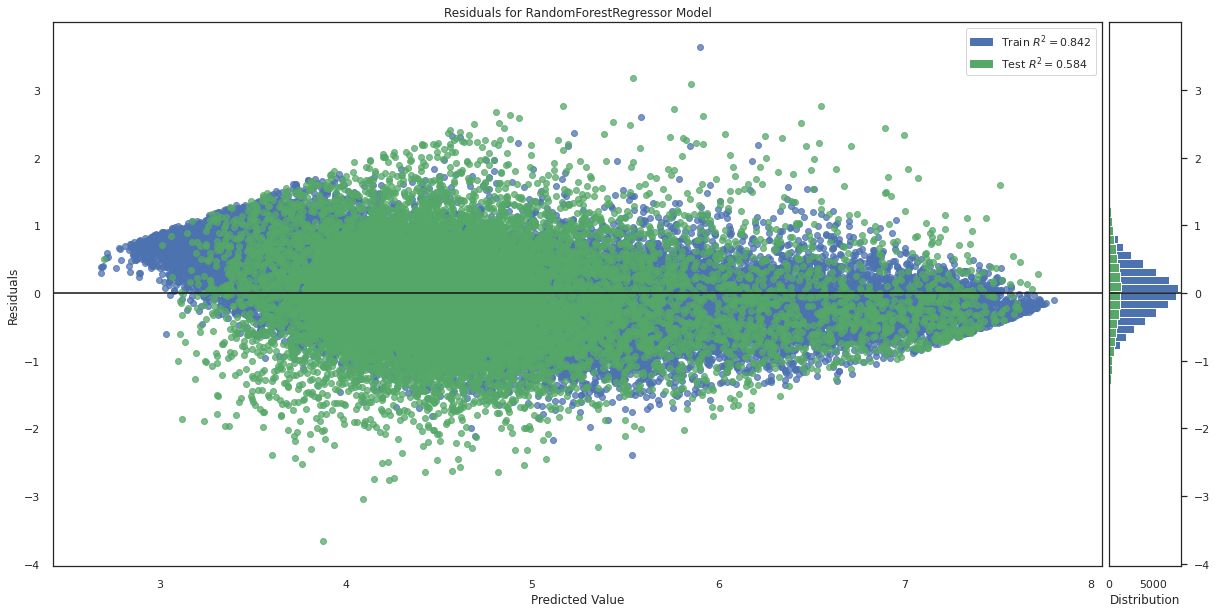

<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [49]:
sns.set(rc={'figure.figsize':(18,10)})
sns.set_style("white")

visualizer = ResidualsPlot(rf)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data

visualizer.show()                 # Finalize and render the figure

#### **Saving Model Object using Pickle File**

In [4]:
import gcsfs

fs = gcsfs.GCSFileSystem(project='aes-datahub-0002')
fs.ls('aes-datahub-0002-curated/Outage_Restoration/Historical_Data/PickleFiles')
# with fs.open('aes-datahub-0002-curated/Outage_Restoration/Historical_Data/PickleFiles/Random_Forest_GridSearch.pkl', 'wb') as f:
#     pickle.dump(rf, f)

['aes-datahub-0002-curated/Outage_Restoration/Historical_Data/PickleFiles',
 'aes-datahub-0002-curated/Outage_Restoration/Historical_Data/PickleFiles/',
 'aes-datahub-0002-curated/Outage_Restoration/Historical_Data/PickleFiles/Random_Forest_GridSearch.pkl']

#### **Load Model Object using Pickle File**

In [5]:
with fs.open('aes-datahub-0002-curated/Outage_Restoration/Historical_Data/PickleFiles/Random_Forest_GridSearch.pkl', 'rb') as f:
    rf_model = pickle.load(f)

EOFError: Ran out of input

#### **Out of Sample Storm Validation**

In [52]:
storm_df = pd.read_csv('gs://aes-datahub-0002-curated/Outage_Restoration/Historical_Data/Master_Dataset/OMS_STORMS_09092020.csv')
storm_df.head()

,CREATION_DATETIME,DNI_EQUIP_TYPE,CALL_QTY,DOWNSTREAM_CUST_QTY,KEY_CUST_QTY,DAY_FLAG,TTR,MAJ_OTG_ID,POLE_CLUE_FLG,PART_LIGHT_CLUE_FLG,EMERGENCY_CLUE_FLG,POWER_OUT_CLUE_FLG,OPEN_DEVICE_CLUE_FLG,TREE_CLUE_FLG,WIRE_DOWN_CLUE_FLG,IVR_CLUE_FLG,EQUIPMENT_CLUE_FLG,TRANSFORMER_CLUE_FLG,OH_CAUSE_FLG,UG_CAUSE_FLG,ANIMAL_CAUSE_FLG,WEATHER_CAUSE_FLG,WEATHER_COLD_CAUSE_FLG,PUBLIC_CAUSE_FLG,WEATHER_LIGHTNING_CAUSE_FLG,WEATHER__SNOW_CAUSE_FLG,WEATHER__WIND_CAUSE_FLG,WEATHER__HEAT_CAUSE_FLG,CUST_REQUEST_CAUSE_FLG,WEATHER__FLOOD_CAUSE_FLG,STREET_CAUSE_FLG,SUBSTATION_CAUSE_FLG,TREE_CAUSE_FLG,MISCELLANEOUS_CAUSE_FLG,NO_CAUSE_FLG,PLANNED_CAUSE_FLG,NO_OUTAGE_CAUSE_FLG,FUSE_OCCURN_FLG,CUST_EQUIP_OCCURN_FLG,POLE_OCCURN_FLG,TRANSFORMER_OCCURN_FLG,METER_OCCURN_FLG,SERVICE_OCCURN_FLG,CABLE_OCCURN_FLG,ST_OCCURN_FLG,FIRE_OCCURN_FLG,FOUND_OPEN_OCCURN_FLG,PUBLIC_SAFETY_OCCURN_FLG,WIRE_OCCURN_FLG,SWITCH_OCCURN_FLG,REGULATOR_OCCURN_FLG,CUTOUT_OCCURN_FLG,CAP_BANK_OCCURN_FLG,RECLOSER_OCCURN_FLG,OH_OCCURN_FLG,PRIORITY_VAL_1.0,PRIORITY_VAL_2.0,PRIORITY_VAL_3.0,PRIORITY_VAL_5.0,CITY_NAM,ZONE,NO_OF_POWER_OUT_CLUE_PER_DAY,NO_OF_OPEN_DEVICE_CLUE_PER_DAY,NO_OF_IVR_CLUE_PER_DAY,NO_OF_ANIMAL_CAUSE_PER_DAY,NO_OF_WIRE_OCCURN_PER_DAY,Hour_Sin,Hour_Cos,RANK_SUBSEQUENT_OUTAGES,Outages_in_last_1hr,Outages_in_last_2hr,Outages_in_last_3hr,Outages_in_last_4hr,Outages_in_last_5hr,Outages_in_last_6hr,Outages_in_last_7hr,Outages_in_last_8hr,Outages_in_last_9hr,Outages_in_last_10hr,Weekday,Weekend_flag,Priority_Customer_Qty,Priority_Dist_Customer_Qty,Dispatch_Location,Date,cldCvrMin,cldCvrAvg,cldCvrMax,dewPtMin,dewPtAvg,dewPtMax,feelsLikeMin,feelsLikeAvg,feelsLikeMax,heatIndexMin,heatIndexAvg,heatIndexMax,mslPresMin,mslPresAvg,mslPresMax,precip,radSolarAvg,radSolarMax,radSolarTot,relHumMin,relHumAvg,relHumMax,sfcPresMin,sfcPresAvg,sfcPresMax,snowfall,spcHumMin,spcHumAvg,spcHumMax,tempMin,tempAvg,tempMax,windChillMin,windChillAvg,windChillMax,windDirAvg,windDir80mAvg,windDir100mAvg,windSpdMin,windSpdAvg,windSpdMax,windSpd80mMin,windSpd80mAvg,windSpd80mMax,windSpd100mMin,windSpd100mAvg,windSpd100mMax,wetBulbMin,wetBulbAvg,wetBulbMax,tempRange,windSpdRange,sfcPresRange,cldCvrRange,relHumRange,relHumRatio,sfcPresRatio
0,2020-07-19 00:06:24,PADELB,4,17,0,False,122.6000,0,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,INDIANAPOLIS,ZONE4,205,10,95,6,16,0.000000,1.000000,1.0,0,0,11,13,13,16,21,25,35,36,Sunday,True,8.0,10.0,MILL,2020-07-19 00:00:00,0.0,31.0,92.0,68.2,72.1,75.2,70.1,81.1,94.4,70.1,81.1,94.4,1011.3,1012.8,1014.0,0.41,239.7,905.1,5753.8,70.1,84.5,94.6,984.3,985.4,986.8,0.0,15.0,17.3,19.3,70.1,77.3,85.8,70.1,77.3,85.8,231.0,238.0,238.0,1.2,8.8,13.8,4.5,14.9,22.6,5.9,15.7,23.9,68.9,73.5,77.8,15.7,12.6,2.5,92.0,24.5,1.349501,1.002540
1,2020-07-19 00:16:04,FUSE,13,20,0,False,67.9333,0,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,INDIANAPOLIS,ZONE4,205,10,95,6,16,0.000000,1.000000,2.0,1,1,11,14,14,16,21,26,35,37,Sunday,True,6.0,12.0,MILL,2020-07-19 00:00:00,0.0,31.0,87.0,68.1,71.9,75.3,69.5,80.3,93.0,69.5,80.3,93.0,1011.1,1012.7,1014.0,0.47,238.3,897.5,5719.3,71.9,85.1,97.9,982.4,983.7,985.3,0.0,15.0,17.2,19.3,69.5,76.8,84.8,69.5,76.8,84.8,235.0,238.0,238.0,0.5,7.7,13.1,6.4,15.3,23.3,7.6,16.3,24.5,68.8,73.2,77.6,15.3,12.6,2.9,87.0,26.0,1.361613,1.002952
2,2020-07-19 00:40:22,1TPUG,4,12,0,False,44.6167,0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,Fa

In [53]:
storm_df = pd.get_dummies(storm_df, columns=['DAY_FLAG', 'POLE_CLUE_FLG', 'PART_LIGHT_CLUE_FLG', 'EMERGENCY_CLUE_FLG', 'POWER_OUT_CLUE_FLG', 
                                   'OPEN_DEVICE_CLUE_FLG', 'TREE_CLUE_FLG', 'WIRE_DOWN_CLUE_FLG', 'IVR_CLUE_FLG', 'EQUIPMENT_CLUE_FLG',
                                   'TRANSFORMER_CLUE_FLG', 'OH_CAUSE_FLG', 'UG_CAUSE_FLG', 'ANIMAL_CAUSE_FLG', 'WEATHER_CAUSE_FLG', 
                                   'WEATHER_COLD_CAUSE_FLG', 'PUBLIC_CAUSE_FLG', 'WEATHER_LIGHTNING_CAUSE_FLG', 'WEATHER__SNOW_CAUSE_FLG', 
                                   'WEATHER__WIND_CAUSE_FLG', 'WEATHER__HEAT_CAUSE_FLG', 'CUST_REQUEST_CAUSE_FLG', 'WEATHER__FLOOD_CAUSE_FLG', 
                                   'STREET_CAUSE_FLG', 'SUBSTATION_CAUSE_FLG', 'TREE_CAUSE_FLG', 'MISCELLANEOUS_CAUSE_FLG', 'NO_CAUSE_FLG', 
                                   'PLANNED_CAUSE_FLG', 'NO_OUTAGE_CAUSE_FLG', 'FUSE_OCCURN_FLG', 'CUST_EQUIP_OCCURN_FLG', 'POLE_OCCURN_FLG', 
                                   'TRANSFORMER_OCCURN_FLG', 'METER_OCCURN_FLG', 'SERVICE_OCCURN_FLG', 'CABLE_OCCURN_FLG', 'ST_OCCURN_FLG',
                                   'FIRE_OCCURN_FLG', 'FOUND_OPEN_OCCURN_FLG', 'PUBLIC_SAFETY_OCCURN_FLG', 'WIRE_OCCURN_FLG', 'SWITCH_OCCURN_FLG', 
                                   'REGULATOR_OCCURN_FLG', 'CUTOUT_OCCURN_FLG', 'CAP_BANK_OCCURN_FLG', 'RECLOSER_OCCURN_FLG', 'OH_OCCURN_FLG', 
                                   'PRIORITY_VAL_1.0', 'PRIORITY_VAL_2.0', 'PRIORITY_VAL_3.0', 'PRIORITY_VAL_5.0', 'CITY_NAM', 
                                   'ZONE', 'Weekday', 'Weekend_flag', 'Dispatch_Location'])

In [54]:
storm_df['CREATION_DATETIME'] = pd.to_datetime(storm_df['CREATION_DATETIME'])
storm_df['Date'] = storm_df['CREATION_DATETIME'].dt.date

In [55]:
storm_df['Date'] = storm_df['Date'].astype(str)
storm_df['Date'].unique()

array(['2020-07-19', '2020-07-20', '2020-07-27', '2020-07-28',
       '2020-08-11'], dtype=object)

In [56]:
storm_19_20July = storm_df[(storm_df['Date'] == '2020-07-19')| (storm_df['Date'] == '2020-07-20')]
storm_27_28July = storm_df[(storm_df['Date'] == '2020-07-27') | (storm_df['Date'] == '2020-07-28')]
storm_11Aug = storm_df[storm_df['Date'] == '2020-08-11']

In [57]:
storm_19_20July = storm_19_20July[storm_19_20July.TTR>30]
storm_27_28July = storm_27_28July[storm_27_28July.TTR>30]
storm_11Aug = storm_11Aug[storm_11Aug.TTR>30]

In [58]:
storm_col = ['MODEL_NAME' , 'TEST_MSE', 'TEST_RMSE', 'TEST_MAE', 'TEST_MAPE', 'TEST_R2']
storm_result_df = pd.DataFrame(columns=storm_col)
storm_test_list = pd.DataFrame() 
i=0

#### **19th & 20th July 2020 Storm**

In [59]:
X = storm_19_20July[final_features]
y = np.log(storm_19_20July.TTR)

y_test_pred = rf_model.predict(X)
y_test_pred = np.exp(y_test_pred)

y = np.exp(y)

mse_test = mean_squared_error(y, y_test_pred)
rmse_test = rmse(y,y_test_pred)
mae_test = mean_absolute_error(y, y_test_pred)
mape_test = mean_absolute_percentage_error(y,y_test_pred)
r2_test = r2_score(y,y_test_pred)

data_test = pd.DataFrame({'Model':'Random Forest 19th & 20th July', 'Test_Predicted': list(y_test_pred),'Test_Actual': list(y)})
storm_test_list = storm_test_list.append(data_test)
storm_test_list.reset_index(drop=True, inplace=True)

storm_result_df.loc[i] = ['Random Forest 19th & 20th July', mse_test, rmse_test, mae_test, mape_test, r2_test]
i = i + 1

In [60]:
storm_result_df.head()

,MODEL_NAME,TEST_MSE,TEST_RMSE,TEST_MAE,TEST_MAPE,TEST_R2
0,Random Forest 19th & 20th July,40616.415581,201.535147,160.802797,187.544762,0.007992


Text(0.5, 1.0, 'Actual vs Fitted : Random Forest 19th & 20th July')

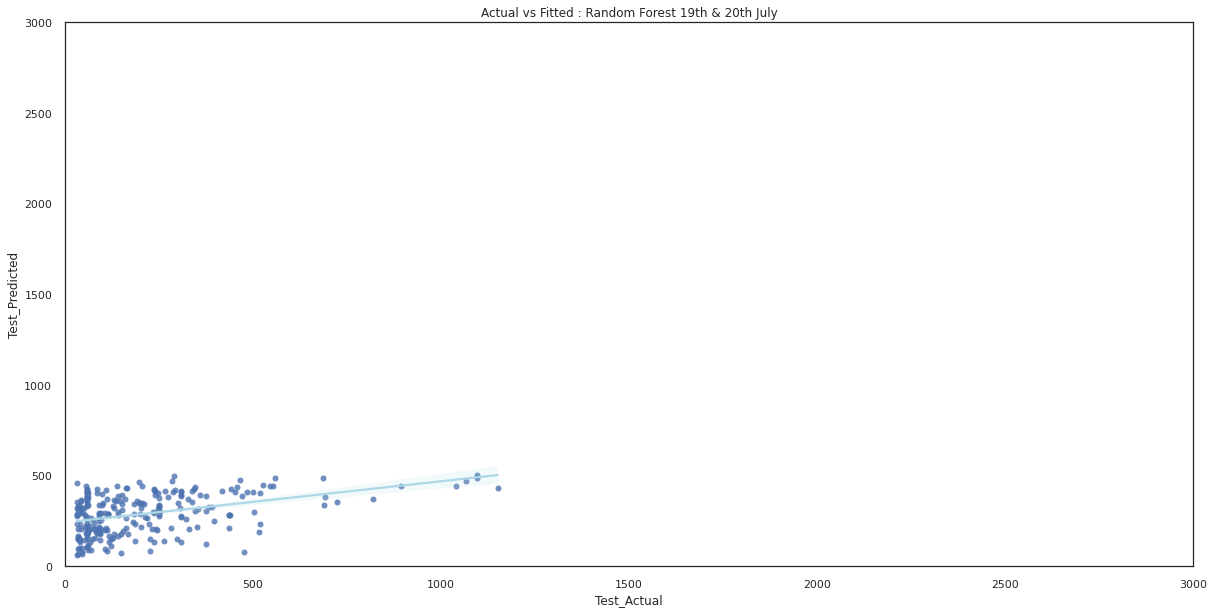

In [61]:
ax = sns.regplot(x="Test_Actual", y="Test_Predicted", data=storm_test_list[storm_test_list.Model=='Random Forest 19th & 20th July'], line_kws={"color": "lightblue"})
ax.set_xlim(0,3000)
ax.set_ylim(0,3000)
ax.set_title('Actual vs Fitted : Random Forest 19th & 20th July')

#### **27th & 28th July 2020 Storm**

In [62]:
X = storm_27_28July[final_features]
y = np.log(storm_27_28July.TTR)

y_test_pred = rf_model.predict(X)
y_test_pred = np.exp(y_test_pred)

y = np.exp(y)

mse_test = mean_squared_error(y, y_test_pred)
rmse_test = rmse(y,y_test_pred)
mae_test = mean_absolute_error(y, y_test_pred)
mape_test = mean_absolute_percentage_error(y,y_test_pred)
r2_test = r2_score(y,y_test_pred)

data_test = pd.DataFrame({'Model':'Random Forest 27th & 28th July', 'Test_Predicted': list(y_test_pred),'Test_Actual': list(y)})
storm_test_list = storm_test_list.append(data_test)
storm_test_list.reset_index(drop=True, inplace=True)

storm_result_df.loc[i] = ['Random Forest 27th & 28th July', mse_test, rmse_test, mae_test, mape_test, r2_test]
i = i + 1

In [63]:
storm_result_df.head()

,MODEL_NAME,TEST_MSE,TEST_RMSE,TEST_MAE,TEST_MAPE,TEST_R2
0,Random Forest 19th & 20th July,40616.415581,201.535147,160.802797,187.544762,0.007992
1,Random Forest 27th & 28th July,105543.109302,324.873990,272.965119,141.368028,0.329026


Text(0.5, 1.0, 'Actual vs Fitted : Random Forest 27th & 28th July')

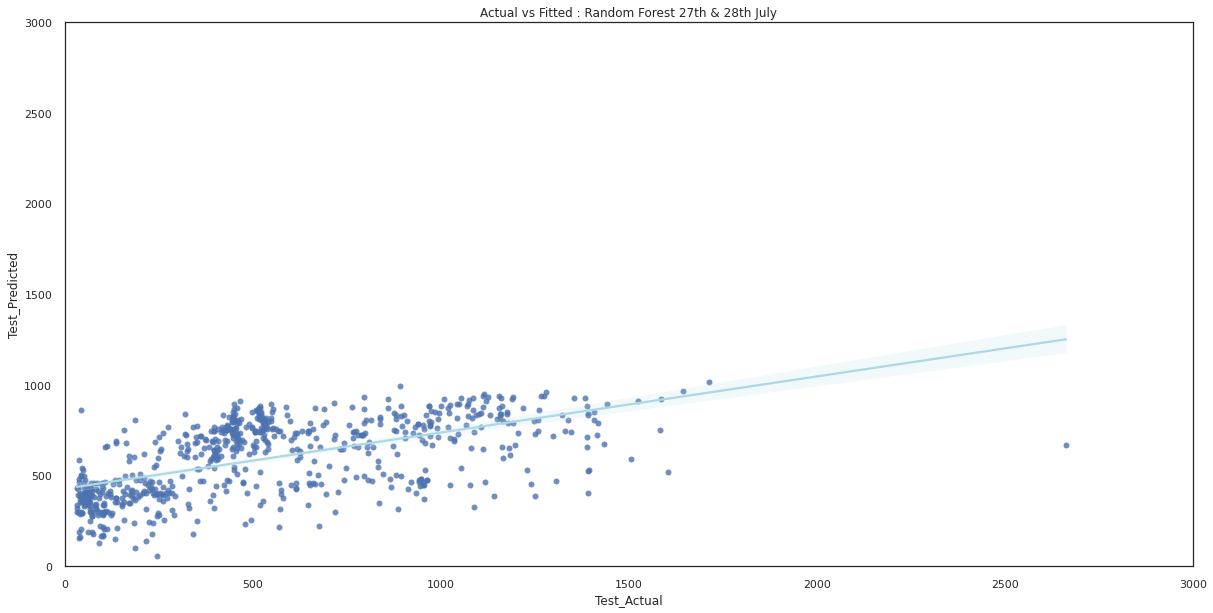

In [64]:
ax = sns.regplot(x="Test_Actual", y="Test_Predicted", data=storm_test_list[storm_test_list.Model=='Random Forest 27th & 28th July'], line_kws={"color": "lightblue"})
ax.set_xlim(0,3000)
ax.set_ylim(0,3000)
ax.set_title('Actual vs Fitted : Random Forest 27th & 28th July')

#### **11th Aug 2020 Storm**

In [65]:
X = storm_11Aug[final_features]
y = np.log(storm_11Aug.TTR)

y_test_pred = rf_model.predict(X)
y_test_pred = np.exp(y_test_pred)

y = np.exp(y)

mse_test = mean_squared_error(y, y_test_pred)
rmse_test = rmse(y,y_test_pred)
mae_test = mean_absolute_error(y, y_test_pred)
mape_test = mean_absolute_percentage_error(y,y_test_pred)
r2_test = r2_score(y,y_test_pred)

data_test = pd.DataFrame({'Model':'Random Forest 11th Aug', 'Test_Predicted': list(y_test_pred),'Test_Actual': list(y)})
storm_test_list = storm_test_list.append(data_test)
storm_test_list.reset_index(drop=True, inplace=True)

storm_result_df.loc[i] = ['Random Forest 11th Aug', mse_test, rmse_test, mae_test, mape_test, r2_test]
i = i + 1

In [66]:
storm_result_df.head()

,MODEL_NAME,TEST_MSE,TEST_RMSE,TEST_MAE,TEST_MAPE,TEST_R2
0,Random Forest 19th & 20th July,40616.415581,201.535147,160.802797,187.544762,0.007992
1,Random Forest 27th & 28th July,105543.109302,324.873990,272.965119,141.368028,0.329026
2,Random Forest 11th Aug,75887.371823,275.476627,226.405394,217.339676,0.109404


Text(0.5, 1.0, 'Actual vs Fitted : Random Forest 11th Aug')

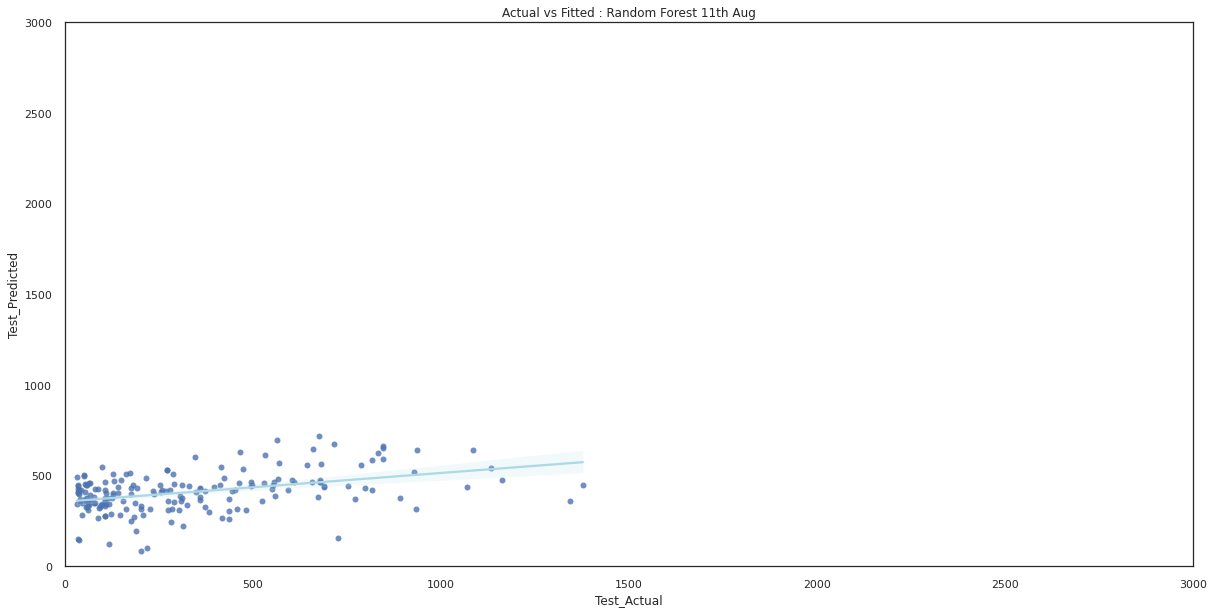

In [67]:
ax = sns.regplot(x="Test_Actual", y="Test_Predicted", data=storm_test_list[storm_test_list.Model=='Random Forest 11th Aug'], line_kws={"color": "lightblue"})
ax.set_xlim(0,3000)
ax.set_ylim(0,3000)
ax.set_title('Actual vs Fitted : Random Forest 11th Aug')

In [68]:
storm_test_list.Model.unique()

array(['Random Forest 19th & 20th July', 'Random Forest 27th & 28th July',
       'Random Forest 11th Aug'], dtype=object)

In [69]:
storm_test_list.to_csv('gs://aes-datahub-0002-curated/Outage_Restoration/Historical_Data/Master_Dataset/storm27thJulyandstorm11thaug.csv')